#### Requirements and preamble

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
# from numba import jit

from utils import *
# from benchmark_utils import print_dict, score_ts
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

from models import *


%load_ext autoreload
%autoreload 2

# Make demonstration dataset

"Detection of periodic driving in nonautonomous difference equations"

(0.0, 0.009259259259259259)

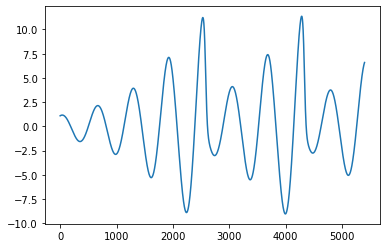

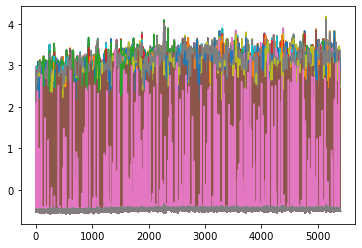

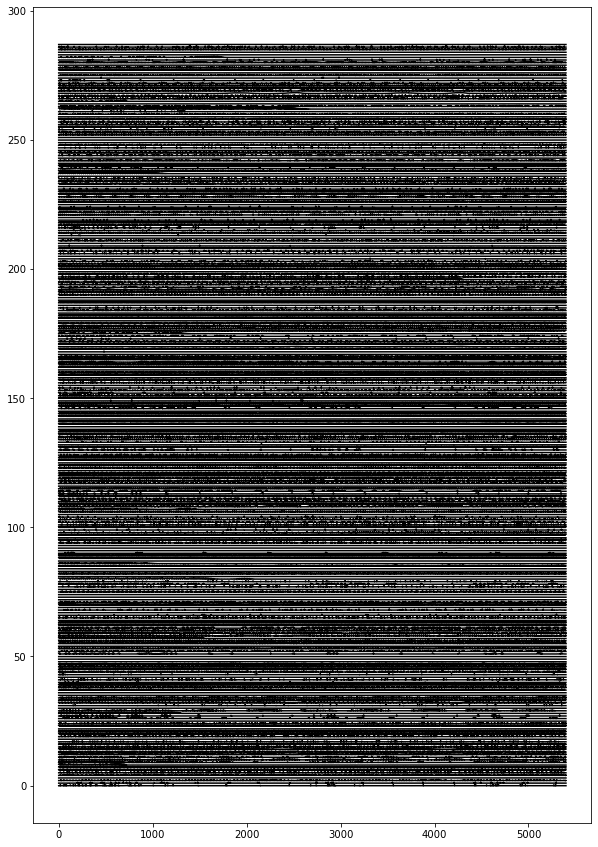

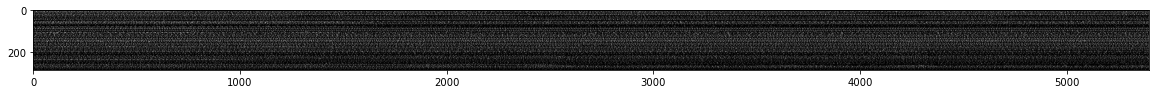

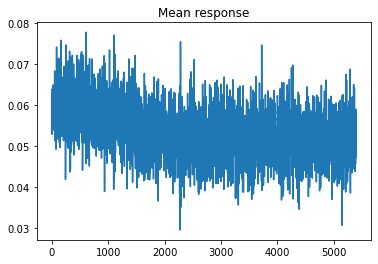

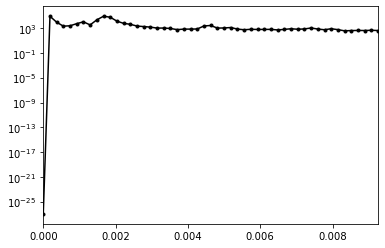

In [3]:
class DrivenLorenz:
    """
    """
    def __init__(self, random_state=None):
        
        # driver properties
        self.ad = 0.5
        self.n = 5.3
        self.r = 1
        
        # response properties
#         self.ar = 1.2
#         self.mu = 8.53
#         self.w = 0.63
        self.rho = 28
        self.beta = 2.667
        self.sigma = 10
        
        self.n_drive = 3
        self.n_response = 3
        
        ## rossler
        self.a = 0.2
        self.b = 0.2
        self.c = 5.7
        
        np.random.seed(random_state)
        self.n_sys = 24
        self.rho = 28 * (1 + 0.5*(np.random.random(self.n_sys) - 0.5))
        self.beta = 2.667 * (1 + 0.1*(np.random.random(self.n_sys) - 0.5))
        self.sigma = 10 * (1 + 0.1*(np.random.random(self.n_sys) - 0.5))
        

        self.n_sys = 12 * 3 * 2 * 4
        self.rho = 28 * (1 + 1 + 0.5*(np.random.random(self.n_sys) - 0.5))
        self.beta = 2.667 * (1 + 0.1*(np.random.random(self.n_sys) - 0.5))
        self.sigma = 10 * (1 + 0.1*(np.random.random(self.n_sys) - 0.5))
        
        
        
        self.rho = 28 * (1 + 1 + 0.1 * (np.random.random(self.n_sys) - 0.5))
        self.beta = 2.667 * (1 + 0.1 * (np.random.random(self.n_sys) - 0.5))
        self.sigma = 10 * (1 + 2 * (np.random.random(self.n_sys) - 0.5))
        
        
        self.rho = 28 * (1 + 5 * (np.random.random(self.n_sys)))
        self.beta = 2.667 * (1 +  0.1 * (np.random.random(self.n_sys)))
        self.sigma = 10 * (1 + 20 * (np.random.random(self.n_sys) ))
        
        
        
        self.rho = 28 * (1 + 2 * 5 * (np.random.random(self.n_sys)))
        self.beta = 2.667 * (1 +  2 * 1 * (np.random.random(self.n_sys)))
        self.sigma = 10 * (1 + 2 * 10 * (np.random.random(self.n_sys) ))
        

    # def rhs_driver(self, t, X):
    #     """Simple periodic driver"""
    #     x, y, z = X
    #     a, n, r = self.ad, self.n, self.r
    #     xdot = a * 15 * np.sin(t / 2) - x
    #     ydot =  a * 15 * np.sin(t / 2) - y
    #     zdot =  a * 15 * np.sin(t / 2) - z
    #     return xdot, ydot, zdot

    def rhs_driver(self, t, X):
        """Rossler driving (aperiodic)"""
        x, y, z = X
        a, b, c = self.a, self.b, self.c
        xdot = -y - z
        ydot = x + a * y
        zdot = b + z * (x - c)
        return xdot * 0.5, ydot * 0.5, zdot * 0.5
    
    def rhs_response_ensemble(self, t, X):
        
        Xd = X[:self.n_drive]
        Xr = X[self.n_drive:]
        
        xd, yd, zd = Xd
        x, y, z = Xr[:self.n_sys], Xr[self.n_sys:2*self.n_sys], Xr[2 * self.n_sys:]

        xdot = self.sigma * (y - x) + self.ar * xd
        ydot = x * (self.rho - z) - y # - self.ar * xd
        zdot = x * y - self.beta * z
        return np.hstack([xdot, ydot, zdot])
    
    def rhs(self, t, X):
        return [*self.rhs_driver(t, X[:self.n_drive]), *self.rhs_response_ensemble(t, X)]
    
eq = DrivenLorenz(random_state=0)

# eq.ar = 20*2 * (np.random.random(eq.n_sys) - 0.5) * 2 # equiv to 20*3

## Strong  signal
eq.ar = 8 * 16 * 20 * np.random.choice([-1, 1], eq.n_sys)

## Weak signal
eq.ar = 16 * 20 * np.random.choice([-1, 1], eq.n_sys)

# eq.ar = 8 * 20 * np.random.choice([-1, 1], eq.n_sys)
eq.ar =  8 * 20 * 2 * (np.random.random(eq.n_sys)  - 0.5)

# rossler
# eq.ar =  16 * 20 * 2 * (np.random.random(eq.n_sys)  - 0.5)
# eq.ar = 4 * 20 * np.random.choice([-1, 1], eq.n_sys) # n = 12

from scipy.integrate import solve_ivp

ic = np.random.random(3 + 3 * eq.n_sys)
ic[:3] = 0.0
#tpts0 = np.linspace(0, 60, 6000)


# sol0 = solve_ivp(eq.rhs, [0, np.max(tpts0)], ic, t_eval=tpts0)

#tpts0 = np.linspace(0, 60, 3000)
tpts0 = np.linspace(0, 3*60, 9000)
sol0 = solve_ivp(eq.rhs, [0, np.max(tpts0)], ic, t_eval=tpts0)

sol = sol0.y.T

transient_frac = 0.4
transient_n = int(transient_frac * len(sol))
sol = sol[transient_n:]
tpts = tpts0[:-transient_n]

sol_drive = sol[:, :3]
sol_response = sol[:, 3:]

# for ensemble
sol_response = np.moveaxis(
    np.reshape(
        sol_response,
        (
            sol_response.shape[0], 
            eq.n_sys, 
            -1
        ),
        order="F"
    ),
    (0, 1, 2), 
    (1, 0, 2)
)
X_measure = sol_response[..., 0]

# def tuning(x):
#     n, nt = X_measure.shape
#     shifts = 20 * (np.random.random(n) - 0.5)[:, None]
#     coeffs = 0.05 * np.random.random(n)[:, None]
#     ramp_coeff = 0.001 * np.random.random(n)[:, None]
#     return np.tanh(coeffs * (x- shifts)) + np.arange(nt)[None, :] *  ramp_coeff
# X_measure = tuning(X_measure)

np.random.seed(10)
from scipy.stats import norm
def tuning(x):
    """
    Apply random response filters to a measured signal
    """
    n, _ = X_measure.shape
    shifts = 10 * (np.random.random(n) - 0.5)[:, None]
    coeffs = 5 * np.random.random(n)[:, None]
    return norm.pdf((x - shifts) / coeffs)
X_measure = tuning(X_measure)


# jj = 3 * np.random.random(eq.ar.shape)
# X_measure = np.tanh(jj[:, None] * X_measure) * (np.random.random(eq.ar.shape)[:, None] - 0.5)

# X_measure *= 60 * np.sin(
#     ((1/(50 * np.random.random(X_measure.shape[0])))[:, None] * np.arange(X_measure.shape[1])[None, :])
# )

plt.figure()
plt.plot(sol_drive[:, 0].T)


plt.figure()
plt.plot(standardize_ts(X_measure).T);



plt.figure(figsize=(10, 15))
for i in range(X_measure.shape[0]):
    #plt.figure(figsize=(10,1))
    plt.plot(i + (1 / 8) * standardize_ts(X_measure)[i].T, 'k');

# More cycles helps a lot, 
# More systems: non-chaotic systems (pushed out of proper driving) really hurt this
# more diverse subsystems doesn't help

plt.figure(figsize=(20, 15))
plt.imshow(X_measure, cmap="gray")

plt.figure()
plt.plot(np.mean(X_measure, axis=0))
plt.title("Mean response")

plt.figure()
all_psd = list()
for i in range(sol_response.shape[0]):
    freqs, psd = find_psd(sol_response[i, :, 0])
    all_psd.append(psd)
    #plt.semilogy(freqs[:100], psd[:100])
plt.semilogy(freqs, np.mean(np.array(all_psd), axis=0), 'k')
plt.semilogy(freqs, np.mean(np.array(all_psd), axis=0), '.k')
plt.xlim([0, 50/sol_response.shape[1]])


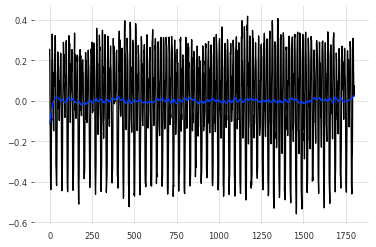

In [ ]:
from dca import DynamicalComponentsAnalysis as DCA



dim_vals = np.array([2, 3, 5, 10, 20, 50, 100, 200, 500, 1000])
t_vals = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])

dca_model = DCA(d=2, T=30)
# oracle DCA: select the timescale we know to be optimal
dca_vals = dca_model.fit_transform(vals_response)
plt.plot(dca_vals[:, 0])
from scipy.signal import savgol_filter
plt.plot(savgol_filter(dca_vals[:, 0], 131, 3))

Current Time:  02:28:22
Current Time:  02:28:22
Computing distance matrix... 

/Users/williamgilpin/program_repos/shrec/models.py:242: UserWarning: 17 Constant time series detected. Skipping these datasets.
  warnings.warn(f"{np.sum(sel_inds)} Constant time series detected. "


Current Time:  02:31:10
done.
Current Time:  02:31:10
Matrix sparsity is:  0.9900000685871057
Current Time:  02:31:10
Assigning pseudotime labels.
test
.....................

Current Time:  02:34:00


Text(0.5, 1.0, 'PCA vs True')

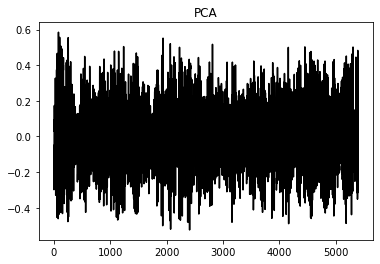

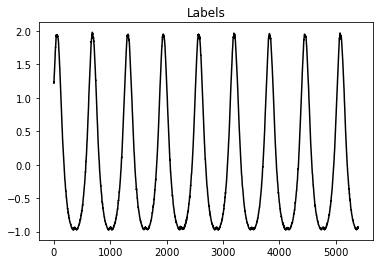

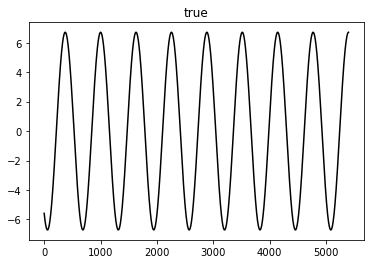

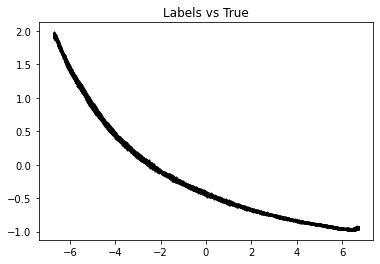

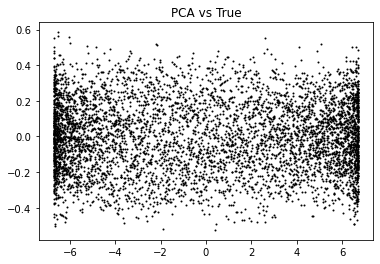

In [60]:
# vals_response = X_measure.T
true_data =  X_measure.T
true_driver0 = sol_drive[:, 0].T

from sklearn.decomposition import PCA
embedding = PCA()
pca_vals = embedding.fit_transform(true_data)[:, 0]


# model = RecurrenceManifold(random_state=0, scale=np.log(2))
# curr_time()
# label_vals0 = model.fit_predict(true_data)
# curr_time()

from models import RecurrenceManifold
# test case
# model = RecurrenceManifold(random_state=0, start=0)
# model = RecurrenceManifold(random_state=0)
model = RecurrenceManifold(random_state=0, 
sampling_method_pseudotime="deterministic_extreme")
# model = RecurrenceManifold(random_state=0)
curr_time()
label_vals0 = model.fit_predict(true_data)
curr_time()


plt.figure()
plt.plot(pca_vals, 'k')
plt.title("PCA")

plt.figure()
plt.plot(label_vals0, 'k')
plt.title("Labels")

plt.figure()
plt.plot(true_driver0, 'k')
plt.title("true")

plt.figure()
plt.plot(true_driver0[:len(label_vals0)], label_vals0, '.k', markersize=2)
plt.title("Labels vs True")


plt.figure()
plt.plot(true_driver0, pca_vals, '.k', markersize=2)
plt.title("PCA vs True")


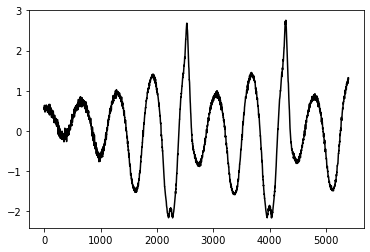

In [57]:
plt.plot(label_vals0, 'k')

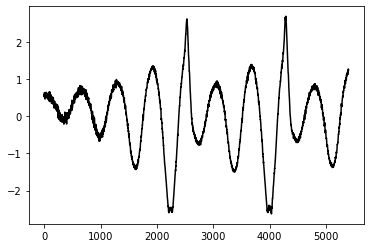

In [43]:
plt.plot(label_vals0, 'k')

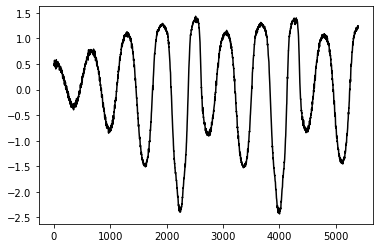

In [20]:
plt.plot(-label_vals0, 'k')

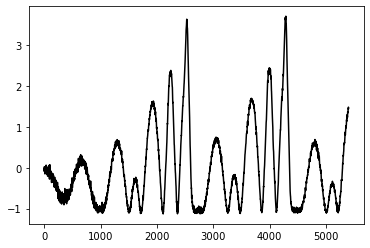

In [18]:
plt.plot(label_vals0, 'k')

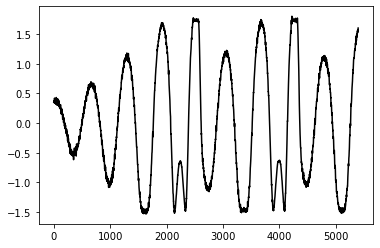

In [16]:
plt.plot(label_vals0, 'k')

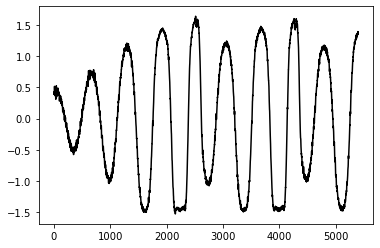

In [14]:
plt.plot(label_vals0, 'k')

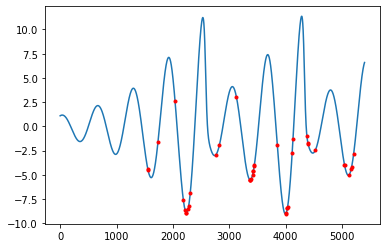

In [58]:
scores = outlier_detection_pca(true_data)

hits = np.argsort(scores)[:20]
hits = np.random.choice(np.arange(len(scores)), 20, p = (1 / scores) / np.sum((1 / scores)), replace=True)
hits = model.all_roots

plt.plot(true_driver0)
plt.plot(hits, true_driver0[hits], '.r')

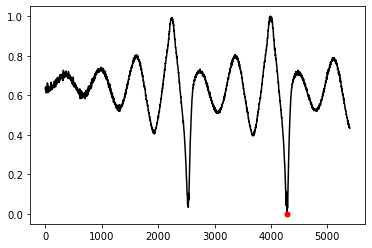

In [193]:
plt.figure()
plt.plot(label_vals0, 'k')
plt.plot(model.start, label_vals0[model.start], '.r', markersize=10)

In [ ]:
import degas as dg

plt.figure(figsize=(10, 15))
plt.plot(sol_drive[:, 0].T)
dg.fixed_aspect_ratio(1/2)
dg.vanish_axes()
# dg.better_savefig("./private_writing/fig_resources/original_signal.pdf")

plt.figure(figsize=(10, 15))
plt.plot(label_vals0)
dg.fixed_aspect_ratio(1/2)
dg.vanish_axes()
# dg.better_savefig("./private_writing/fig_resources/original_signal.pdf")




plt.figure(figsize=(10, 15))
for i in range(10):
    #plt.figure(figsize=(10,1))
    plt.plot(i + (1 / 4) * standardize_ts(X_measure)[i, :600].T);

dg.fixed_aspect_ratio(1/2)
dg.vanish_axes()
# dg.better_savefig("./private_writing/fig_resources/corrupted_output.pdf")

# Baseline Implementations


Dependencies

+ sktime >0.13 with all extras
+ elephant
+ quantities
+ neo
+ filterpy
+ pykalman

Algorithms

+ PCA *
+ DCA *
+ Fourier
+ Causal AE
+ GPFA: https://elephant.readthedocs.io/en/latest/tutorials/gpfa.html
+ SFA *
+ Kalman *
+ LFADS

In [23]:
import torch
from lfads import LFADS_Net

device = 'cuda' if torch.cuda.is_available() else 'cpu'; print('Using device: %s'%device)

true_data =  X_measure.T
true_driver0 = sol_drive[:, 0].T

hyperparams = {
    'betas': (0.9, 0.99),
    'c_encoder_dim': 128,
    'clip_val': 5.0,
    'controller_dim': 128,
    'dataset_name': 'test',
    'epsilon': 0.1,
    'factors_dim': 20,
    'g0_encoder_dim': 200,
    'g0_prior_kappa': 0.1,
    'g_dim': 200,
    'keep_prob': 0.95,
    'kl_weight_schedule_dur': 2000,
    'kl_weight_schedule_start': 0,
    'l2_con_scale': 0,
    'l2_gen_scale': 2000,
    'l2_weight_schedule_dur': 2000,
    'l2_weight_schedule_start': 0,
    'learning_rate': 0.01,
    'learning_rate_decay': 0.95,
    'learning_rate_min': 1e-05,
    'max_norm': 200,
    'run_name': 'demo',
    'scheduler_cooldown': 6,
    'scheduler_on': True,
    'scheduler_patience': 6,
    'u_dim': 1,
    'u_prior_kappa': 0.1
}



train_data = np.array([true_data, true_data])
train_data = torch.Tensor(train_data[:, :2000]).to(device)
valid_data = torch.Tensor(train_data[:, 2000:4000]).to(device)

train_truth = torch.Tensor(true_driver0[:2000]).to(device)
valid_truth = torch.tensor(true_driver0[2000:4000]).to(device)

train_ds = torch.utils.data.TensorDataset(train_data)
valid_ds = torch.utils.data.TensorDataset(valid_data)
num_trials, num_steps, num_cells = train_data.shape

model = LFADS_Net(inputs_dim = num_cells, T = num_steps, dt = 0.01, device=device,
                 model_hyperparams=hyperparams).to(device)





Using device: cpu
Random seed: 3492


In [28]:
train_data.shape

torch.Size([2, 2000, 288])

In [15]:
model.fit(train_ds, valid_ds, max_epochs=200, batch_size=200, use_tensorboard=False,
          train_truth=train_truth, valid_truth=valid_truth)

Beginning training...


AssertionError: 

In [6]:

model.load_checkpoint('best')
model.plot_summary(data=valid_data, truth=valid_truth)



In [45]:
# def FourierModel:
#     """
#     Reconstruct a signal by finding dominant frequencies in the time domain.
#     """
#     def __init__(self, max_freqs=100, random_state=0):
#         self.max_freqs = max_freqs
#         self.random_state = random_state

#     def fit(self, X, y=None):
#         self.embedding_ = FourierEmbedding(n_components=self.n_components, random_state=self.random_state)
#         self.embedding_.fit(X)
#         pass



# BATCH_SUBSAMPLE = 1 
from benchmarks.classification_models import Autoencoder, TimeSeriesCollection
from torch.utils.data import DataLoader 

import torch
import torch.nn as nn
from torch import optim

SEQUENCE_LENGTH = 10

# def CausalAutoencoder:

model = Autoencoder()
training_data = TimeSeriesCollection(true_data[:1000, :8], SEQUENCE_LENGTH)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(200): 
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, outputs = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(inputs, outputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
print("Finished training autoencoder.", flush=True)

encoded_ts = model.encoder(torch.tensor(X_train_np, dtype=torch.float32)).detach().numpy()

# X_train_nn = from_3d_numpy_to_nested()

KeyboardInterrupt: 

In [46]:
training_data

In [43]:
 DataLoader(training_data, batch_size=1000, shuffle=True)

AttributeError: 

In [42]:
encoded_ts = model.encoder(torch.tensor(true_data[:1000, :8], dtype=torch.float32)).detach().numpy()

RuntimeError: Expected 3-dimensional input for 3-dimensional weight [16, 1, 3], but got 2-dimensional input of size [1000, 8] instead

In [40]:
encoded_ts 

NameError: name 'encoded_ts' is not defined

In [38]:
true_data.shape

(5400, 288)

Initializing parameters using factor analysis...

Fitting GPFA model...


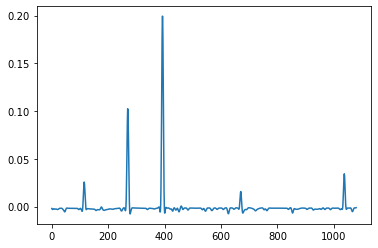

In [20]:
from elephant.gpfa import GPFA
import quantities as pq
import neo


# specify parameters
bin_size = 5 * pq.ms
latent_dimensionality = 4


def ts_to_spikes(sig):
    """Convert a time series to spiking data whenever it exceeds a threshold."""
    thresh = np.median(sig)
    sig_c = sig - thresh
    out = np.where(np.diff(np.sign(sig_c)))[0] ## zero crossings
    return out
    # sig = np.abs(sig)
    # thresh = np.median(sig)
    # out = np.where(sig > thresh)[0]
    # return out



# simple time seires to spike conversion
# true_data2 = true_data[:, np.var(true_data, axis=0) != 0]
# # true_data2 += 1e-1 * np.mean(true_data2) * np.random.random(size=true_data2.shape)
# spiketrains = [[neo.SpikeTrain(ts_to_spikes(row)* pq.ms, t_stop=len(row) * pq.ms) for row in true_data2[:, :20].T]]


## Inhomogenous Poisson Process based on observed variables
from elephant.spike_train_generation import inhomogeneous_poisson_process
n_trials = 50
timestep = pq.ms
spiketrains = []
for _ in range(num_trials):
    spiketrains_per_trial = []
    for inst_rate in true_data.T:
        anasig_inst_rate = neo.AnalogSignal(inst_rate, sampling_rate=1/timestep, units=pq.Hz)
        spiketrains_per_trial.append(inhomogeneous_poisson_process(anasig_inst_rate))
    spiketrains.append(spiketrains_per_trial)

model = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)
trajectories = model.fit_transform(spiketrains)[0]
average_trajectory = PCA().fit_transform(trajectories.T)[:, 0]

from sklearn.decomposition import PCA
plt.plot(average_trajectory)

Initializing parameters using factor analysis...

Fitting GPFA model...


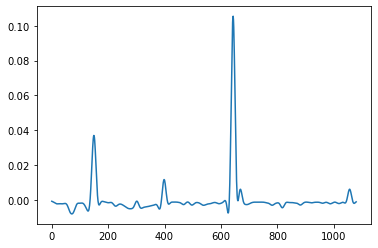

In [ ]:
# Sample a random driving signal

# sample random measurement functions of the driver

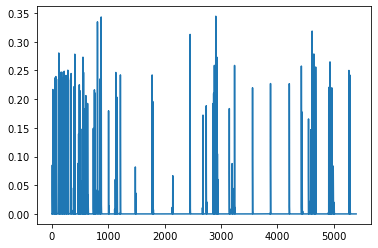

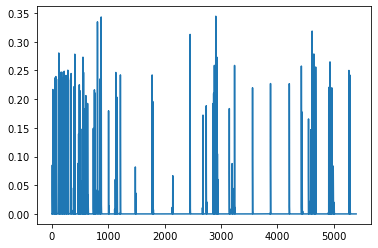

In [15]:
import sktime.transformations.series.kalman_filter as kf

true_data =  X_measure.T
true_driver0 = sol_drive[:, 0].T

model = kf.KalmanFilterTransformerFP(state_dim=1)
out = model.fit_transform(true_data)  

plt.figure()
plt.plot(out[:, 0])


model = kf.KalmanFilterTransformerPK(state_dim=1)
out = model.fit_transform(true_data)  

plt.figure()
plt.plot(out[:, 0])

In [7]:
import sktime

dir(sktime.utils)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_maint']

In [57]:
np.hstack([true_data[:, :35], true_data[:, 40:50]])

(5400, 45)

In [ ]:
## Script

+ Validation set: select hyper parameters
+ Random seed
+ tolerances, latent dimensionality

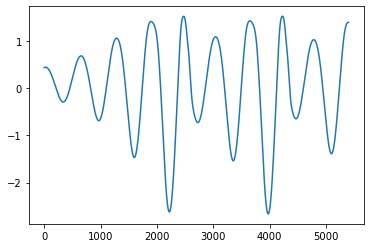

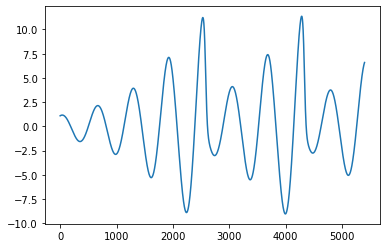

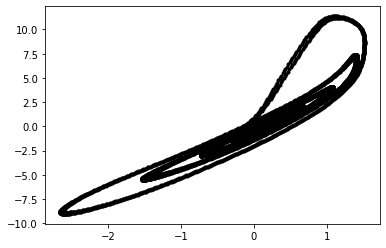

In [3]:
import sksfa

true_data =  X_measure.T
true_driver0 = sol_drive[:, 0].T

model = sksfa.SFA(n_components=1, random_state=0)
out = model.fit_transform(true_data)


plt.figure()
plt.plot(out[:, 0])

plt.figure()
plt.plot(true_driver0)


plt.figure()
plt.plot(out[:, 0], true_driver0, '.k')

# Experimental Datasets

## Worm neurons Kato et al

From [here](https://osf.io/y8a6e/)

<KeysViewHDF5 ['IDs', 'States', 'dataset', 'fps', 'stimulus', 'timeVectorSeconds', 'traces', 'tracesDif', 'traces_raw']>
<KeysViewHDF5 ['conc', 'concunits', 'identity', 'initialstate', 'switchtimes', 'type']>
[[ 4.]
 [21.]]
[[79]
 [50]]

 <HDF5 object reference>
Current Time:  04:26:06
Computing distance matrix... Current Time:  04:26:17
done.
Current Time:  04:26:17
Matrix sparsity is:  0.9900000082795096
Current Time:  04:26:17
Assigning pseudotime labels.
test
.....................



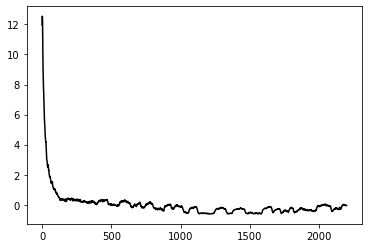

In [426]:
# dpath = "/Users/williamgilpin/Downloads/WT_NoStim.mat"
dpath = "/Users/williamgilpin/Downloads/WT_Stim.mat"


# from scipy.io.matlab import loadmat
# loadmat(dpath)

import h5py

# traces_raw
keyname = "WT_Stim"
with h5py.File(dpath, 'r') as f:
    print(f[keyname].keys())
   #true_driving = np.array(f[f[keyname]["States"][0][0]]) # these are based on the PCA, 
    m2 = f[keyname]["stimulus"][0][0]
    print(f[m2].keys())
    print(np.array(f[m2]['conc']))
    print(np.array(f[m2]['identity']))
#     print(np.array(f[m2]['identity']))
    true_driving = np.squeeze(np.array(f[m2]['switchtimes']))
#     print(f[keyname]["stimulus"][0])

    
    m1 = f[keyname]["traces_raw"][0][0]
    print("\n", m1)
    data = np.array(f[m1])
    tpts =np.squeeze(np.array(f[f[keyname]["timeVectorSeconds"][0][0]]))
    
true_data = data.T


# model = RecurrenceManifold(random_state=0) 
model = RecurrenceManifold(random_state=0, sampling_method_pseudotime="deterministic_extreme")
label_vals = model.fit_predict(true_data)

pca_vals = PCA().fit_transform(true_data)

plt.figure()
plt.plot(label_vals[:], 'k')


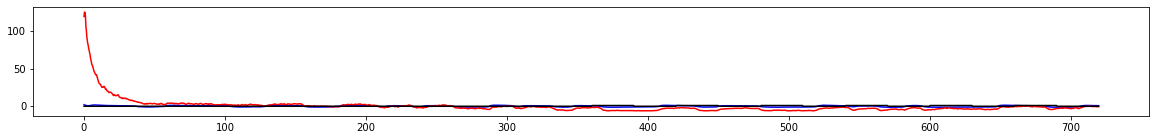

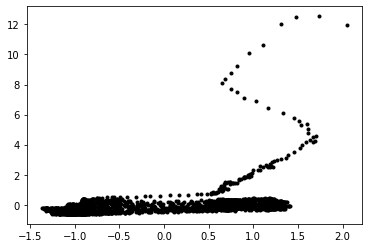

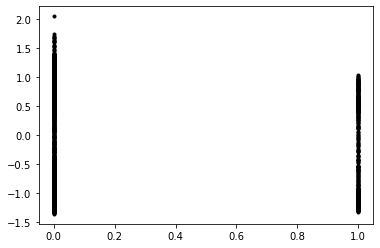

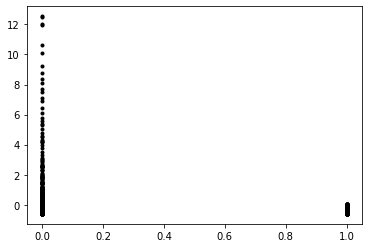

In [427]:
sig = np.zeros_like(tpts)
for bkpt in true_driving:
    sig[tpts > bkpt] = 1 - sig[tpts > bkpt]


plt.figure(figsize=(20, 2))
plt.plot(tpts, pca_vals[:, 0], 'b')
plt.plot(tpts, 10*label_vals, 'r')
plt.plot(tpts, sig, 'k')

plt.figure()
plt.plot(pca_vals[:, 0], label_vals, '.k')

plt.figure()
plt.plot(sig, pca_vals[:, 0], '.k')

plt.figure()
plt.plot(sig, label_vals, '.k')

# Rat hippocampus

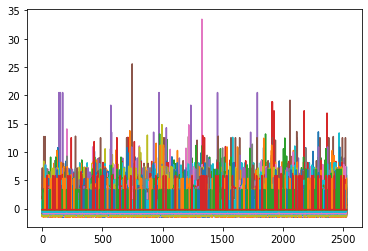

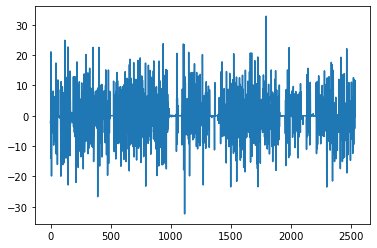

In [12]:
# neurons, positions = np.load("/Users/williamgilpin/Downloads/example_data_hc.pickle", allow_pickle=True)
# true_data = neurons[200:][::5][:3000] # drop nans
# positions =  positions[200:][::5][:3000] # drop nans
# true_driver0 = PCA().fit_transform(
#     np.vstack([nan_fill(positions[:, 0]), nan_fill(positions[:, 1])]).T
# )[:, 0]

## best
neurons, positions = np.load("/Users/williamgilpin/Downloads/example_data_m1.pickle", allow_pickle=True)
true_data = neurons[:, :][::10][:3000]
true_driver0 = PCA().fit_transform(
    np.vstack([nan_fill(positions[:, 0]), nan_fill(positions[:, 1])]).T
)[:, 0][::10][:3000]

## bad
# neurons, positions = np.load("/Users/williamgilpin/Downloads/example_data_s1.pickle", allow_pickle=True)
# true_data = neurons[400:][:3000]
# # true_driver0 = positions[400:][:3000, 0]
# # true_driver0 = nan_fill(true_driver0)
# true_driver0 = PCA().fit_transform(
#     np.vstack([nan_fill(positions[:, 0]), nan_fill(positions[:, 1])]).T
# )[:, 0][400:][:3000]


# true_data = savgol_filter(true_data, 201, 3, axis=0)
# true_driver0 = savgol_filter(true_driver0, 101, 3, axis=0)
# from scipy.ndimage import gaussian_filter1d
# from scipy.signal import medfilt
# true_data = gaussian_filter1d(true_data, 21, axis=0)
# true_driver0 = gaussian_filter1d(true_driver0, 21)

# true_data = medfilt(true_data, kernel_size=(121, 1))
# true_driver0 = medfilt(true_driver0, 121)

# true_data = np.hstack([true_data, np.random.random(true_data.shape), np.random.random(true_data.shape)])
# true_data = standardize_ts(true_data)
# true_data = detrend_ts(true_data)
# true_driver0 = np.squeeze(detrend_ts(true_driver0[:, None]))


plt.figure()
plt.plot(standardize_ts(true_data));
plt.figure()
plt.plot(true_driver0)

Current Time:  02:01:46
Current Time:  02:01:46
Computing distance matrix... Current Time:  02:02:12
done.
Current Time:  02:02:12
Matrix sparsity is:  0.9900001562280304
Current Time:  02:02:12
Assigning pseudotime labels.
test
.....................

Current Time:  02:02:44


Text(0.5, 1.0, 'true')

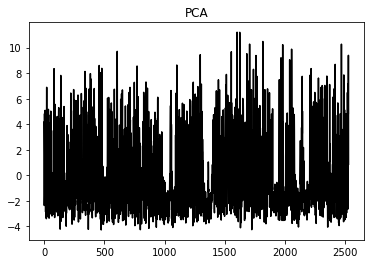

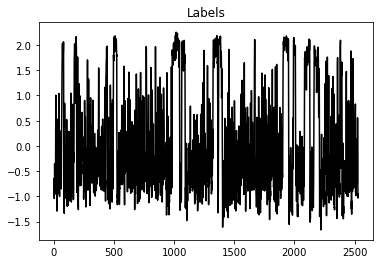

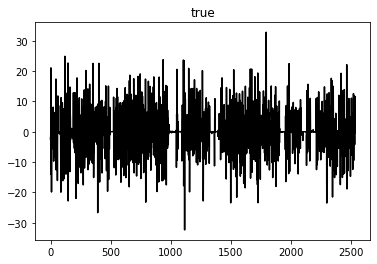

In [46]:
true_data = detrend_ts(true_data)
true_driver = detrend_ts(true_driver0)

from sklearn.decomposition import PCA
embedding = PCA()
data_pca = embedding.fit_transform(true_data)[:, 0]

model = RecurrenceManifold(random_state=0, sampling_method_pseudotime="deterministic_extreme")
# model = RecurrenceManifold(random_state=0)

curr_time()
label_vals0 = model.fit_predict(true_data)
curr_time()


plt.figure()
plt.plot(data_pca, 'k')
plt.title("PCA")

plt.figure()
plt.plot(label_vals0, 'k')
plt.title("Labels")

plt.figure()
plt.plot(true_driver0, 'k')
plt.title("true")

True versus found
0.25 mutual_info
2.32 conditional_info
0.74 conditional_info_back
1.12 mae
13926.95 mape
10.36 marre
1.92 mse
-0.92 r2_score
1.39 rmse
155.49 smape
-0.06 spearman
-0.04 pearson
-0.04 kendalltau
0.36 sync
0.09 coherence
0.99 coherence_phase
0.07 cross forecast error
0.06 cross forecast error neural
0.07 cross forecast error neural 2
0.35 dynamic time warping distance


True versus PCA
0.23 mutual_info
2.59 conditional_info
0.86 conditional_info_back
1.07 mae
7500.88 mape
9.93 marre
1.87 mse
-0.87 r2_score
1.37 rmse
156.64 smape
0.01 spearman
0.06 pearson
0.01 kendalltau
0.56 sync
0.11 coherence
0.26 coherence_phase
0.11 cross forecast error
0.1 cross forecast error neural
0.06 cross forecast error neural 2
0.39 dynamic time warping distance




Text(0.5, 1.0, 'Labels vs PCA: -0.19074778334296072 3.7142127455335205e-22')

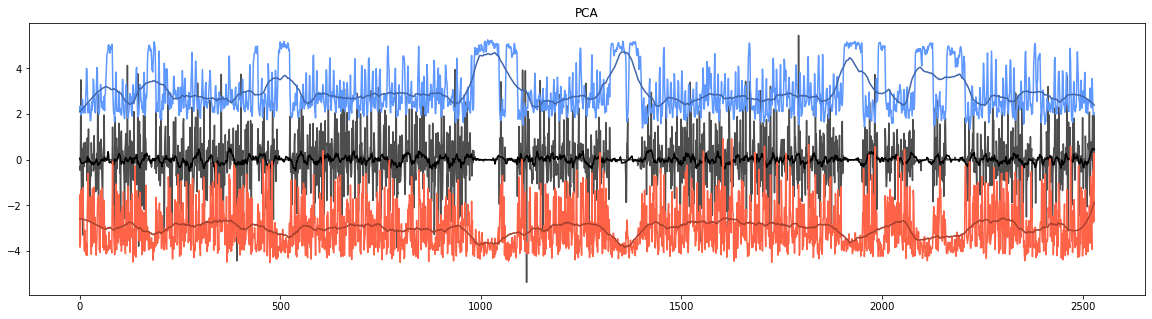

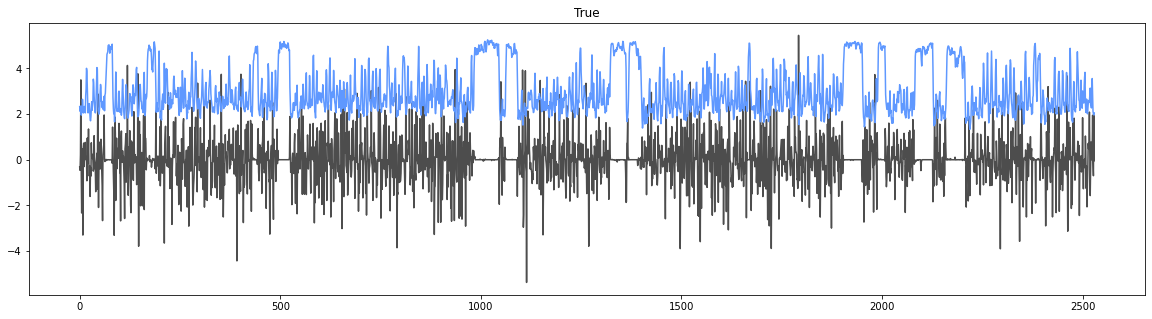

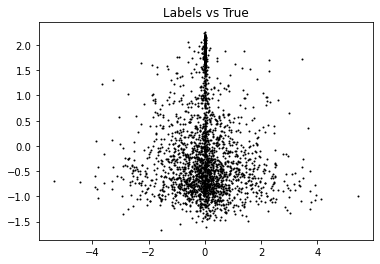

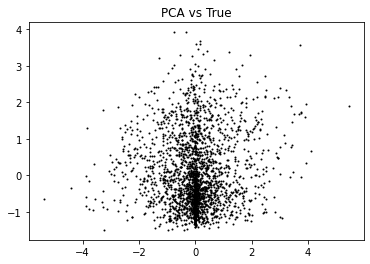

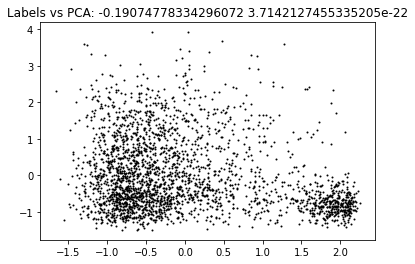

In [47]:
import degas as dg
from scipy.signal import savgol_filter
from scipy.stats import spearmanr

true_driver = standardize_ts(true_driver0)
label_vals = standardize_ts(label_vals0)
pca_vals = standardize_ts(data_pca)

# sort_inds = np.argsort(true_driver)
# true_driver = true_driver[sort_inds]
# label_vals = label_vals[sort_inds]
# pca_vals = pca_vals[sort_inds]

## derivatives
# true_driver = standardize_ts(np.diff(true_driver0))
# label_vals =  standardize_ts(np.diff(nan_fill(label_vals0)))
# pca_vals = standardize_ts(np.diff(data_pca))

# label_vals = savgol_filter(label_vals, 131, 3)
# pca_vals = savgol_filter(pca_vals, 131, 3)
# true_driver = 10 * savgol_filter(true_driver, 131, 3)

# label_vals = standardize_ts(savgol_filter(label_vals0, 11, 3, deriv=1))
# pca_vals = standardize_ts(savgol_filter(data_pca, 11, 3, deriv=1))
# true_driver = standardize_ts(savgol_filter(true_driver0, 11, 3, deriv=1))

# pca_vals = np.random.random(pca_vals.shape)

plt.figure(figsize=(20, 5))
plt.plot(true_driver,  color=(0.3, 0.3, 0.3))
plt.plot(savgol_filter(true_driver, 31, 3), 'k')
plt.title("True")

# plt.figure()
plt.plot(3 + label_vals, color=dg.blue)
plt.plot(savgol_filter(3 + label_vals, 131, 3), color=dg.darker(dg.blue))
# plt.plot(np.cumsum(label_vals - np.mean(label_vals)))
plt.title("Labels")

# plt.figure()
plt.plot(-3 + pca_vals, color=dg.red)
plt.plot(savgol_filter(-3 + pca_vals , 131, 3), color=dg.darker(dg.red))
plt.title("PCA")

plt.figure(figsize=(20, 5))
plt.plot(true_driver,  color=(0.3, 0.3, 0.3))
plt.plot(3 + label_vals, color=dg.blue)
plt.title("True")


plt.figure()
plt.plot(true_driver, label_vals, '.k', markersize=2)
print("True versus found")
print_dict(score_ts(true_driver, label_vals))
plt.title("Labels vs True")


plt.figure()
plt.plot(true_driver, pca_vals, '.k', markersize=2)
print("True versus PCA")
print_dict(score_ts(true_driver, pca_vals))
plt.title("PCA vs True")

plt.figure()
plt.plot(label_vals, pca_vals, '.k', markersize=2)
corr = spearmanr(label_vals, pca_vals)
plt.title("Labels vs PCA: " + str(corr.correlation) + " " + str(corr.pvalue))


In [18]:
all_label_scores, all_pca_scores = list(), list()
ts = 500
keyname = "mutual_info"
keyname = "spearman" # no detrending
for i in np.random.choice(np.arange(len(true_driver) - ts), 30, replace=False):
    scores = score_ts(true_driver[i:i+ts], label_vals[i:i+ts])
    all_label_scores.append(scores[keyname])

    scores = score_ts(true_driver[i:i+ts], pca_vals[i:i+ts])
    all_pca_scores.append(scores[keyname])
    
print(np.mean(all_label_scores), np.std(all_label_scores))
print(np.mean(all_pca_scores), np.std(all_pca_scores))

0.14797713270853083 0.1693793435872174
0.2041101924407697 0.12286370632224286


# Mouse head direction

[Source](https://portal.nersc.gov/project/crcns/download/th-1/data)

Similar dataset [here](https://crcns.org/data-sets/hc/hc-2)

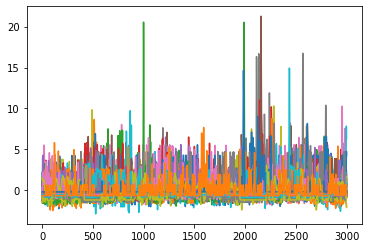

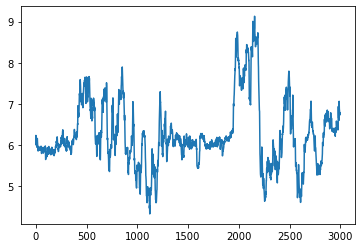

In [14]:

from scipy.signal import savgol_filter
from utils import load_pickle_file

data_dir = "/Users/williamgilpin/Dropbox (Personal)/attractor/code/resources/analyses/2019_03_kernel_rates/100ms_sigma/Mouse28-140313.p"
d = load_pickle_file(data_dir)

all_recordings = list()
for key in d['Wake'][(5565.0,7851.4)]["rates"]:
    all_recordings.append( d['Wake'][(5565.0,7851.4)]["rates"][key])
    

# true_data = np.vstack(all_recordings)[:, :3000].T
# true_data = standardize_ts(true_data)
# true_driver = d['Wake'][(5565.0,7851.4)]["angles"][:3000]
# true_driver = unroll_phase(nan_fill(true_driver))

true_data = np.vstack(all_recordings)[:, :].T[200:][:3000]
true_data = standardize_ts(true_data)
true_driver0 = d['Wake'][(5565.0,7851.4)]["angles"][200:][:3000]
true_driver0 = unroll_phase(nan_fill(true_driver0))

plt.figure()
plt.plot(true_data);

#np.vstack(true_data.dump("test_head_direction_neurons.pkl")

plt.figure()
plt.plot(true_driver0)



(5313240000,)
(55346250, 96)
(775980,)
71.32432536921054


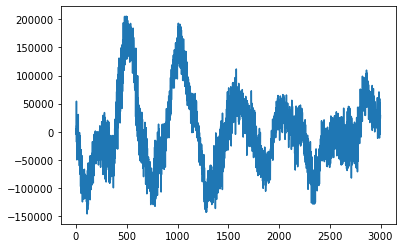

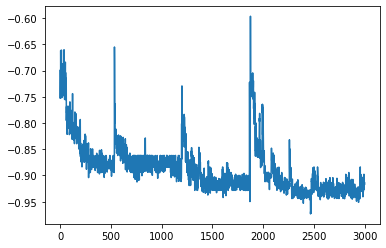

In [432]:

# n_channels = 96 # in XML file
# n_channels = 90 # in XML file


# raw_signal = np.loadtxt("/Users/williamgilpin/Downloads/AngFiles/Mouse12-120810.ang")
# raw_signal[raw_signal == -1] = None
# true_signal = unroll_phase(nan_fill(raw_signal))
# true_signal = true_signal[::100][:2000][25:]


# mouse_name = "Mouse12-120810"
# dpath = "/Users/williamgilpin/Downloads/Mouse12-120810-01.dat"
# n_channels = 96 # in XML file
# dpath = "/Users/williamgilpin/Downloads/Mouse12-120810/" + mouse_name + ".eeg"
# raw_signal = np.loadtxt("/Users/williamgilpin/Downloads/AngFiles/" + mouse_name + ".ang")
# n_channels = 90 # in XML file

# mouse_name = "Mouse28-140313"
# dpath = "/Users/williamgilpin/Downloads/" + mouse_name + "/" + mouse_name  + ".eeg"
# raw_signal = np.loadtxt("/Users/williamgilpin/Downloads/" + mouse_name + "/" + mouse_name + ".ang")
# n_channels = 96 # in XML file

dpath = "/Users/williamgilpin/Downloads/Mouse12-120810-01.dat"
raw_signal = np.loadtxt("/Users/williamgilpin/Downloads/AngFiles/Mouse12-120810.ang")
n_channels = 90 # in XML file


#  20kHz
with open(dpath, 'r') as f:
    a = np.fromfile(f, dtype=np.uint16) # bit depth in file
print(a.shape)
raw_data = np.reshape(a, (n_channels, -1), order="C").T
print(raw_data.shape)

raw_signal[raw_signal == -1] = None
raw_signal = np.sin(unroll_phase(nan_fill(raw_signal)))
print(raw_signal.shape)

# Downsample to match timescales
dsamp = raw_data.shape[0] / raw_signal.shape[0]
print(dsamp)
from scipy.signal import resample
raw_data = raw_data[::int(np.round(dsamp)), :]

raw_data = raw_data[6000:][::15][:3000]
raw_signal = raw_signal[6000:][::15][:3000]
# raw_data = raw_data[19000:][::7][:12000]
# raw_signal = raw_signal[19000:][::7][:12000]
# raw_data = raw_data[3000:][::4][:6000]
# raw_signal = raw_signal[3000:][::4][:6000]

from sklearn.decomposition import PCA
embedding = PCA()
data_transformed = embedding.fit_transform(raw_data)

true_data = raw_data
true_driver0 = raw_signal

plt.figure()
plt.plot(data_transformed[:, 0])

plt.figure()
plt.plot(raw_signal)


Current Time:  02:05:31
Current Time:  02:05:31
Computing distance matrix... 

/Users/williamgilpin/program_repos/shrec/models.py:242: UserWarning: 1 Constant time series detected. Skipping these datasets.
  warnings.warn(f"{np.sum(sel_inds)} Constant time series detected. "


Current Time:  02:05:45
done.
Current Time:  02:05:45
Matrix sparsity is:  0.9900002222222222
Current Time:  02:05:45
Assigning pseudotime labels.
test
.........................................

Current Time:  02:07:13


Text(0.5, 1.0, 'true')

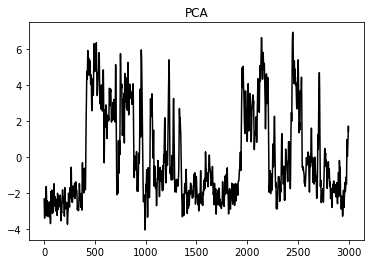

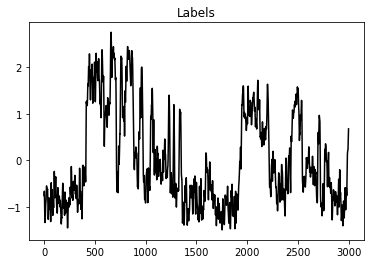

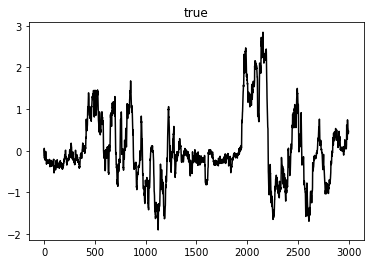

In [52]:
true_data = detrend_ts(true_data)
true_driver = np.squeeze(detrend_ts(true_driver0[:, None]))

from sklearn.decomposition import PCA
embedding = PCA()
data_pca = embedding.fit_transform(true_data)[:, 0]


model = RecurrenceManifold(random_state=0, n_samples_pseudotime=40, 
sampling_method_pseudotime="deterministic_extreme")
# model = RecurrenceManifold(random_state=0)

curr_time()
label_vals0 = model.fit_predict(true_data)
curr_time()


plt.figure()
plt.plot(data_pca, 'k')
plt.title("PCA")

plt.figure()
plt.plot(label_vals0, 'k')
plt.title("Labels")

plt.figure()
plt.plot(true_driver, 'k')
plt.title("true")

0.15 mutual_info
0.55 conditional_info
0.58 conditional_info_back
0.78 mae
524.83 mape
13.13 marre
0.9 mse
0.1 r2_score
0.95 rmse
110.59 smape
0.44 spearman
0.55 pearson
0.25 kendalltau
0.69 sync
0.06 coherence
0.11 coherence_phase
0.12 cross forecast error
0.16 cross forecast error neural
0.67 cross forecast error neural 2
0.17 dynamic time warping distance


0.13 mutual_info
0.59 conditional_info
0.66 conditional_info_back
0.7 mae
503.09 mape
11.73 marre
0.7 mse
0.3 r2_score
0.84 rmse
103.64 smape
0.54 spearman
0.65 pearson
0.35 kendalltau
0.72 sync
0.08 coherence
0.06 coherence_phase
0.15 cross forecast error
0.19 cross forecast error neural
0.63 cross forecast error neural 2
0.16 dynamic time warping distance




Text(0.5, 1.0, 'Labels vs PCA: 0.9043819875979986 0.0')

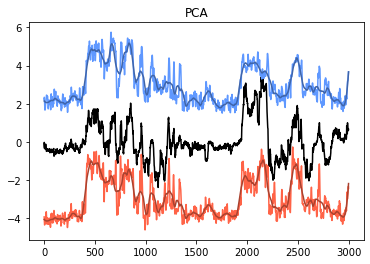

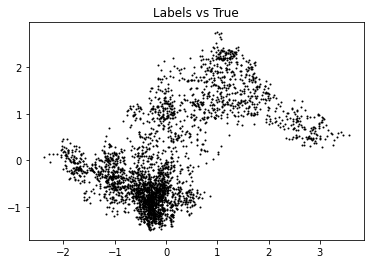

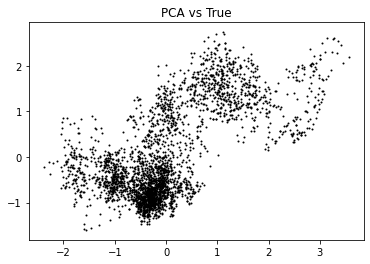

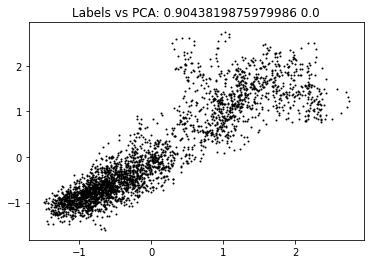

In [53]:
import degas as dg
from scipy.signal import savgol_filter

true_driver = standardize_ts(true_driver0)
label_vals = standardize_ts(label_vals0)
pca_vals = standardize_ts(data_pca)

## derivatives
# true_driver = np.squeeze(standardize_ts(np.diff(true_driver)[:, None]))
# label_vals = np.squeeze(standardize_ts(np.diff(nan_fill(label_vals0))[:, None]))
# pca_vals = np.squeeze(standardize_ts(np.diff(data_pca)[:, None]))

# label_vals = savgol_filter(label_vals, 131, 3)
# pca_vals = savgol_filter(pca_vals, 131, 3)

# label_vals = savgol_filter(label_vals0, 41, 3, deriv=1)
# pca_vals = savgol_filter(data_pca, 41, 3, deriv=1)
# true_driver = savgol_filter(true_driver0, 41, 3, deriv=1)



plt.figure()
plt.plot(true_driver, 'k')
plt.title("True")

# plt.figure()
plt.plot(3 + label_vals, color=dg.blue)
plt.plot(savgol_filter(3 + label_vals, 131, 3), color=dg.darker(dg.blue))
# plt.plot(np.cumsum(label_vals - np.mean(label_vals)))
plt.title("Labels")

# plt.figure()
plt.plot(-3 + pca_vals, color=dg.red)
plt.plot(savgol_filter(-3 + pca_vals , 131, 3), color=dg.darker(dg.red))
plt.title("PCA")




plt.figure()
plt.plot(true_driver, label_vals, '.k', markersize=2)
print_dict(score_ts(true_driver, label_vals))
plt.title("Labels vs True")


plt.figure()
plt.plot(true_driver, pca_vals, '.k', markersize=2)
print_dict(score_ts(true_driver, pca_vals))
plt.title("PCA vs True")

plt.figure()
plt.plot(label_vals, pca_vals, '.k', markersize=2)
corr = spearmanr(label_vals, pca_vals)
plt.title("Labels vs PCA: " + str(corr.correlation) + " " + str(corr.pvalue))


In [ ]:
# METRIC: need a metric that rewards catching dips and spikes

# Plankton time series

+ All factors have statistically significant correlations
+ Direction of correlation matches Granger analysis
+ Correlations with water level and temperature, both factors identified as drivers via a Granger causality analysis

Current Time:  04:13:43
Current Time:  04:13:43
Computing distance matrix... Current Time:  04:13:43
done.
Current Time:  04:13:43
Matrix sparsity is:  0.9900137741046832
Current Time:  04:13:43
Assigning pseudotime labels.
test
.....................

Current Time:  04:13:43


Text(0.5, 1.0, 'Labels vs PCA')

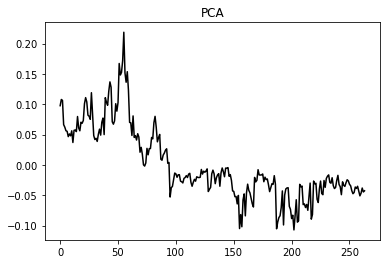

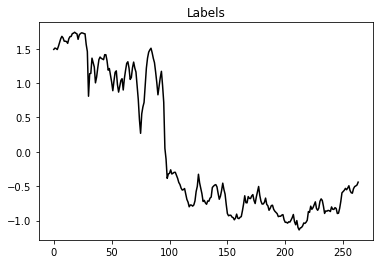

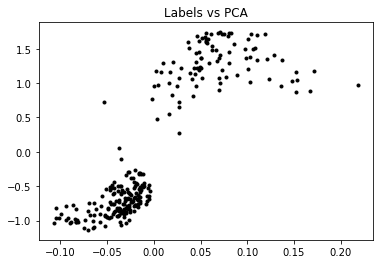

In [411]:
true_data = np.load("./resources/phytoplankton_species_abundances.pkl", allow_pickle=True)
true_data = true_data.T

# true_data += 0.01 * np.random.random(true_data.shape)

# from scipy.signal import resample, savgol_filter
# all_out = list()
# for row in true_data.T:
#     sig = resample(row, len(row) * 8)
#     sig = savgol_filter(sig, 31, 3)
#     all_out.append(sig)
# true_data = np.vstack(all_out).T

# true_data = np.load("data_elec.pkl", allow_pickle=True)
# true_data = true_data.T[np.var(true_data, axis=0) > 0].T[:2000, :50]


from sklearn.decomposition import PCA
embedding = PCA()
data_pca = embedding.fit_transform(true_data)[:, 0]

curr_time()
model = RecurrenceManifold(random_state=0,  sampling_method_pseudotime="deterministic_extreme")
label_vals0 = model.fit_predict(true_data)
curr_time()


plt.figure()
plt.plot(data_pca, 'k')
plt.title("PCA")

plt.figure()
plt.plot(label_vals0, 'k')
plt.title("Labels")

plt.figure()
plt.plot(data_pca, label_vals0, '.k')
plt.title("Labels vs PCA")


In [415]:
import pandas as pd
from utils import nan_fill

DATA_PATH = "resources/41467_2017_2571_MOESM4_ESM.xlsx"
DATA_PATH = "resources/41467_2017_2571_MOESM6_ESM.xlsx"

data = pd.read_excel(DATA_PATH)
data = data.set_index("OTU")
data = data.transpose()

# Drop metadata in last row
data.drop(data.tail(1).index, inplace=True)

METADATA_PATH = "resources/41467_2017_2571_MOESM10_ESM.xlsx"
metadata = pd.read_excel(METADATA_PATH)
metadata = metadata.set_index("OrdinalDay")
metadata.drop(metadata.tail(1).index, inplace=True)

for key in metadata.keys():
    metadata[key][metadata[key] == "nd"] = np.nan
    metadata[key] = nan_fill(np.array(metadata[key]))
#     try:
#         metadata[key][metadata[key] == "nd"] = None
#     except:
#         pass
#         metadata[key][np.array(metadata[key]) == "nd"] = np.nan


/var/folders/g_/3gcjjjc12l9cjdh8drtctrdm0000gp/T/ipykernel_1263/4269543917.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata[key][metadata[key] == "nd"] = np.nan
/var/folders/g_/3gcjjjc12l9cjdh8drtctrdm0000gp/T/ipykernel_1263/4269543917.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata[key][metadata[key] == "nd"] = np.nan
/var/folders/g_/3gcjjjc12l9cjdh8drtctrdm0000gp/T/ipykernel_1263/4269543917.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [423]:
spearmanr(true_driver, label_vals).correlation

0.5349220848779009

/var/folders/g_/3gcjjjc12l9cjdh8drtctrdm0000gp/T/ipykernel_1263/3761738672.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


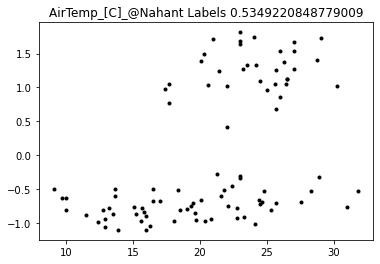

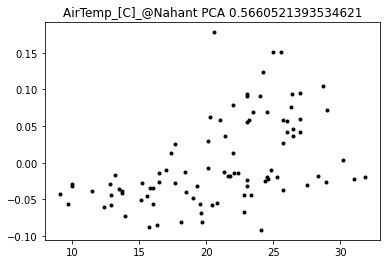

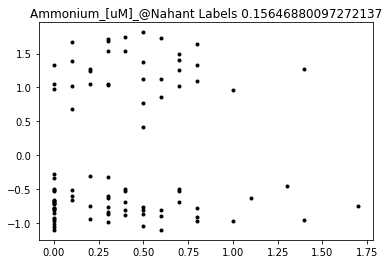

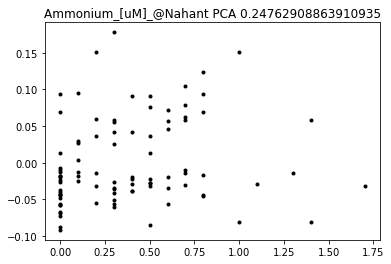

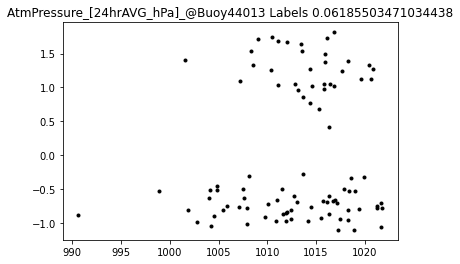

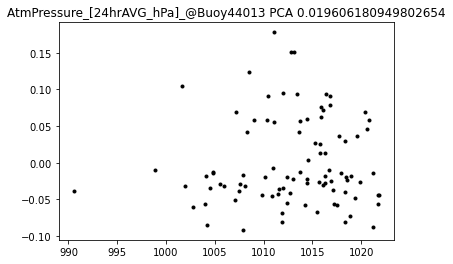

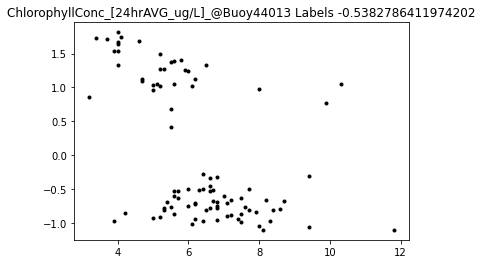

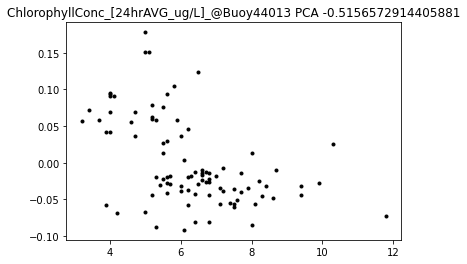

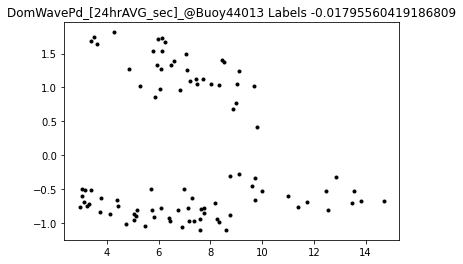

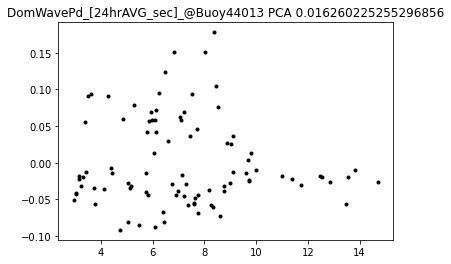

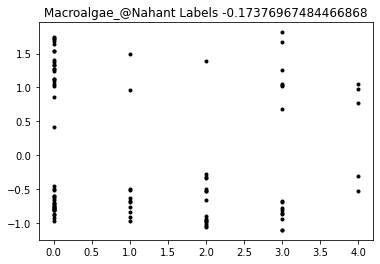

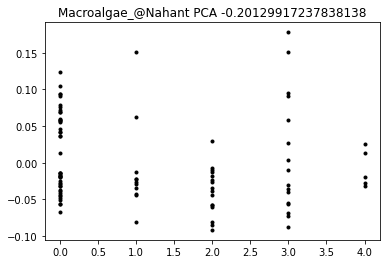

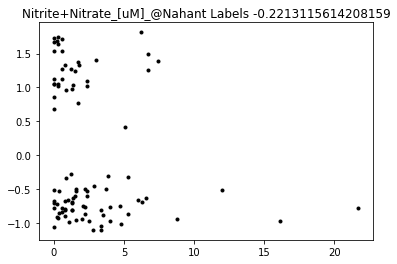

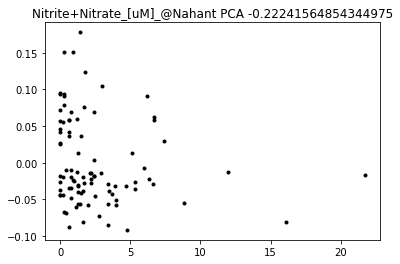

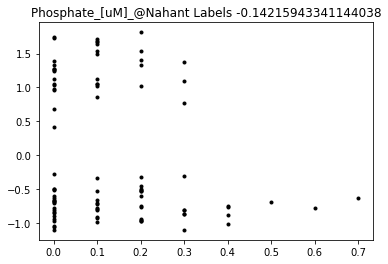

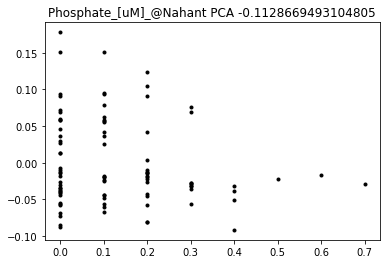

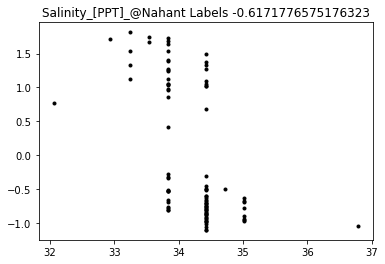

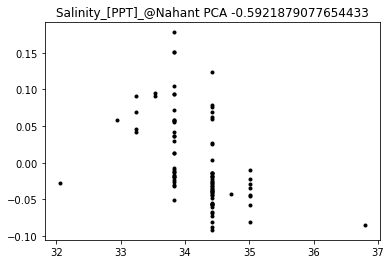

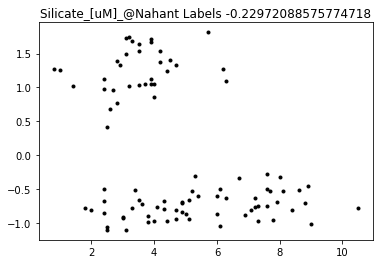

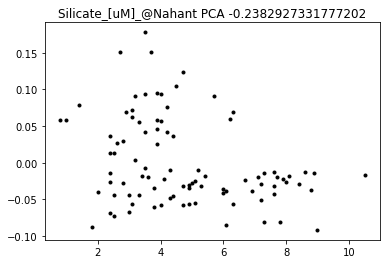

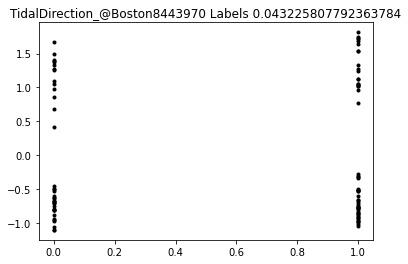

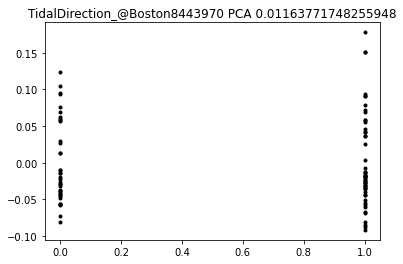

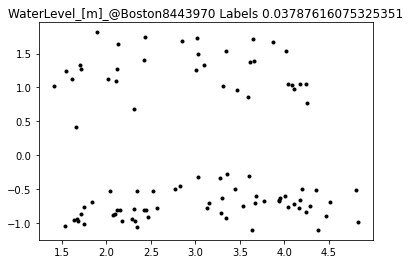

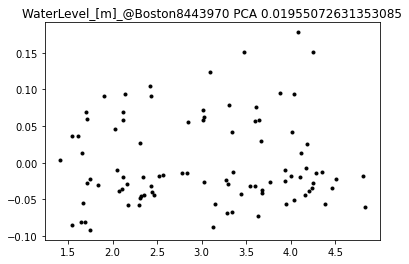

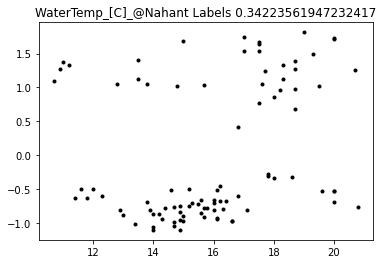

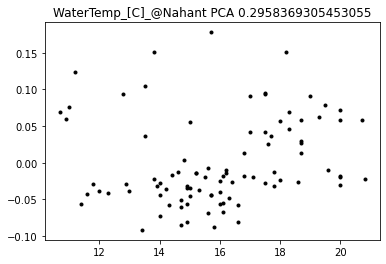

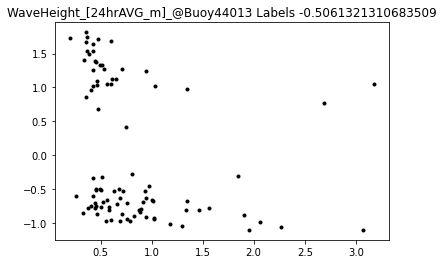

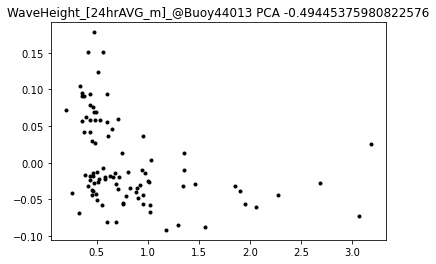

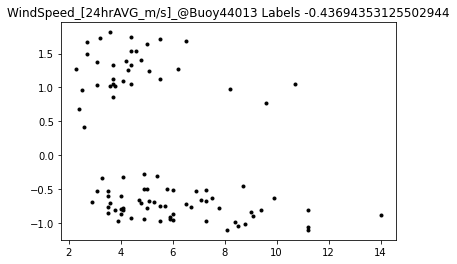

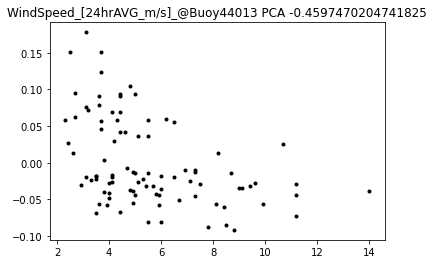

In [424]:
from scipy.stats import spearmanr
from scipy.signal import resample

all_drivers = list()
for key in metadata:
    true_driver = np.array(metadata[key].astype(float))
    true_driver = nan_fill(true_driver).astype(float)
    all_drivers.append(true_driver)
    
#     true_driver = resample(true_driver, len(label_vals))
#     plt.figure()
# #     plt.plot(true_driver)
#     plt.plot(true_driver, label_vals, '.k', markersize=1)
#     plt.title(key + ' ' + str(spearmanr(true_driver, label_vals).correlation) )
#     print(key, " ", spearmanr(true_driver, label_vals), flush=True)
    
    
    label_vals = resample(label_vals0, len(true_driver))
    pca_vals = resample(data_pca, len(true_driver))
    
    
#     plt.plot(true_driver)
    #print_dict(score_ts(true_driver, label_vals))
    # print_dict(score_ts(true_driver, pca_vals))
    # print("-------")
    
    plt.figure()
    plt.plot(true_driver, label_vals, '.k')
    plt.title(key + " Labels" + " " + str(spearmanr(true_driver, label_vals).correlation))
    
    plt.figure()
    plt.plot(true_driver, pca_vals , '.k')
    plt.title(key + " PCA" + " " + str(spearmanr(true_driver, pca_vals).correlation))
    

    
all_drivers = np.vstack(all_drivers).T

all_drivers_pca = PCA().fit_transform(all_drivers)

# Electricity

Current Time:  04:12:44
Computing distance matrix... Current Time:  04:12:53
done.
Current Time:  04:12:53
Matrix sparsity is:  0.9900005
Current Time:  04:12:53
Assigning pseudotime labels.
test
.....................



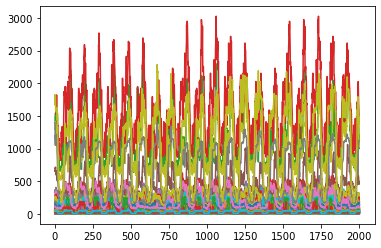

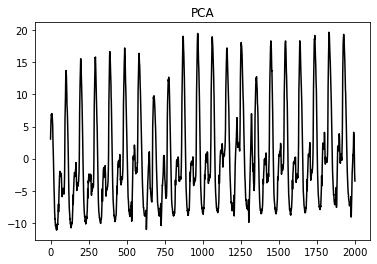

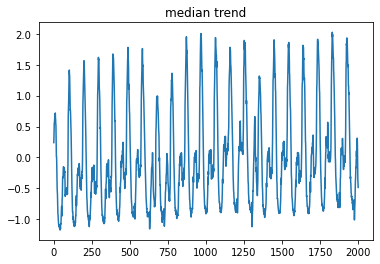

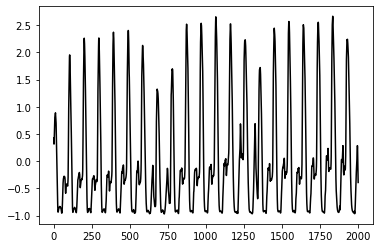

In [409]:
true_data = np.load("./resources/data_elec.pkl", allow_pickle=True)
true_data = true_data.T[np.var(true_data, axis=0) > 0].T[:2000, :100]

# true_data += np.random.random(true_data.shape)

plt.figure()
plt.plot(true_data);

from sklearn.decomposition import PCA
embedding = PCA()
data_pca = embedding.fit_transform(standardize_ts(true_data))
plt.figure()
plt.plot(data_pca[:, 0], 'k')
plt.title("PCA")

model = RecurrenceManifold(random_state=0,  sampling_method_pseudotime="deterministic_extreme")
label_vals = model.fit_predict(true_data) 

# # model.fit(true_data, root_index=np.argmin(np.mean(standardize_ts(true_data), axis=-1)))
# # label_vals = model.labels_


# # # # model = RecurrenceClustering()
# # # # label_vals = model.fit_predict(trude_data[:4000, 12])

plt.figure()
plt.plot(np.median(standardize_ts(true_data), axis=-1))
plt.title("median trend")

plt.figure()
plt.plot(label_vals, 'k')


# Equities

This looks like VIX, even though vix is calculated using information not available to the model

Daily closing prices from Yahoo finance

Current Time:  04:50:02
Current Time:  04:50:02
Current Time:  04:52:01
Current Time:  04:52:01
Matrix sparsity is:  0.99000001002003
Current Time:  04:52:01
asymmetry:  0.0
Current Time:  04:52:03
Assigning pseudotime labels.
....................



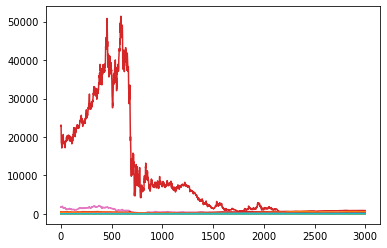

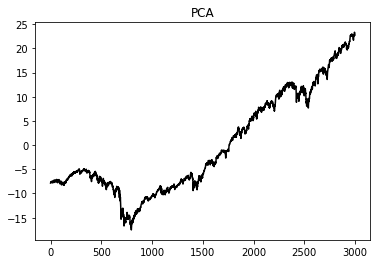

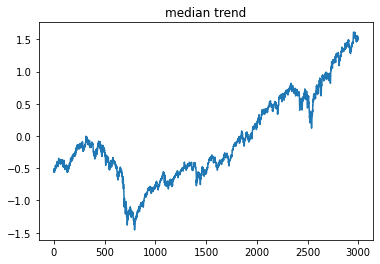

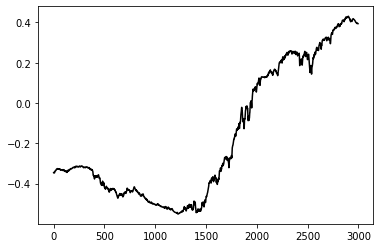

In [1459]:
true_data = np.load("stocks.pkl", allow_pickle=True)

# true_data = true_data[:, :120]

# true_data += 0.001 * np.random.random(true_data.shape)

# from scipy.signal import resample, savgol_filter
# all_out = list()
# for row in true_data.T:
#     sig = resample(row, len(row) * 8)
#     sig = savgol_filter(sig, 31, 3)
#     all_out.append(sig)
# true_data = np.vstack(all_out).T

# true_data = np.load("data_elec.pkl", allow_pickle=True)
# true_data = true_data.T[np.var(true_data, axis=0) > 0].T[:2000, :50]

plt.figure()
plt.plot(true_data);

from sklearn.decomposition import PCA
embedding = PCA()
data_pca = embedding.fit_transform(standardize_ts(true_data))
plt.figure()
plt.plot(data_pca[:, 0], 'k')
plt.title("PCA")

model = RecurrenceManifold(weighted_connectivity=True, start="multiple")
label_vals = model.fit_predict(true_data) 

# model.fit(true_data, root_index=np.argmin(np.mean(standardize_ts(true_data), axis=-1)))
# label_vals = model.labels_


# # # model = RecurrenceClustering()
# # # label_vals = model.fit_predict(trude_data[:4000, 12])

plt.figure()
plt.plot(np.median(standardize_ts(true_data), axis=-1))
plt.title("median trend")

plt.figure()
plt.plot(label_vals, 'k')

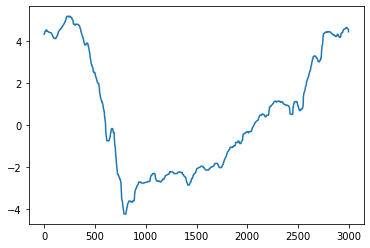

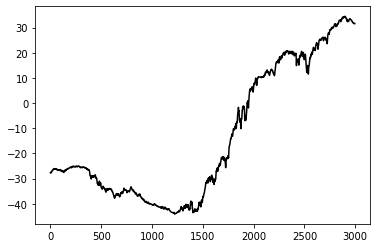

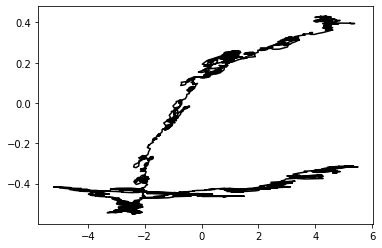

In [1467]:
from scipy.signal import detrend
import pandas as pd
from scipy.signal import medfilt

# df = pd.read_csv("big_data/stock/1 Day/Stocks/aapl.us.txt")
# df = pd.read_csv("big_data/stock/1 Day/ETFs/schb.us.txt")
# df = pd.read_csv("big_data/stock/1 Day/ETFs/aapl.us.txt")


df = pd.read_csv("big_data/stock/1 Day/ETFs/pey.us.txt")

# df = pd.read_csv("big_data/stock/VTI.csv")
# df = pd.read_csv("big_data/stock/vix.csv")
mask = (df['Date'] > '2006-01-09') & (df['Date'] <= '2017-12-06')
df = df.loc[mask]
sig = df["Close"].to_numpy()


# sig = sig - ((sig[-1] - sig[0]) / len(sig)) * np.arange(len(sig)) + sig[0]
# m, b = np.polyfit(np.arange(len(sig)), sig, 1)
# sig = sig - (m *np.arange(len(sig)) + b)
## detrend exponential growth
m, b = np.polyfit(np.arange(len(sig)), np.log(sig), 1)
sig = sig - (np.exp(m * np.arange(len(sig))) * np.exp(b))

plt.figure()
plt.plot(medfilt(sig, 51))

plt.figure()
plt.plot(80 * label_vals, 'k')



plt.figure()
plt.plot(sig[:len(label_vals)], label_vals, 'k')

In [ ]:
import glob

for i, dpath in enumerate(glob.glob("big_data/stock/1 Day/ETFs/*")):
    try:
        df = pd.read_csv(dpath)
        mask = (df['Date'] > '2006-01-09') & (df['Date'] <= '2017-12-06')
        df = df.loc[mask]
        sig = df["Close"].to_numpy()

        ## detrend exponential growth
        m, b = np.polyfit(np.arange(len(sig)), np.log(sig), 1)
        sig = sig - (np.exp(m * np.arange(len(sig))) * np.exp(b))
        corr = np.abs(scipy.stats.kendalltau(sig[:len(label_vals)], label_vals).correlation)
        if corr > 0.5:
            print(corr, " ", dpath, flush=True)
        else:
            pass
    except:
        pass
        

# MIMIC-III Heart rate, ECG, respiration

In [402]:
true_data = np.load("./resources/physio.pkl", allow_pickle=True)
true_driver0 = np.load("./resources/physio_drive.pkl", allow_pickle=True)

# all_out = list()
# for row in true_data.T:
#     sig = row
#     #sig = resample(row, len(row) * 8)
#     sig = savgol_filter(sig, 101, 3)
#     all_out.append(sig)
# true_data = np.vstack(all_out).T

Current Time:  04:08:48
Current Time:  04:08:48
Computing distance matrix... Current Time:  04:08:49
done.
Current Time:  04:08:49
Matrix sparsity is:  0.9900002222222222
Current Time:  04:08:49
Assigning pseudotime labels.
test
.....................

Current Time:  04:09:27


Text(0.5, 1.0, 'true')

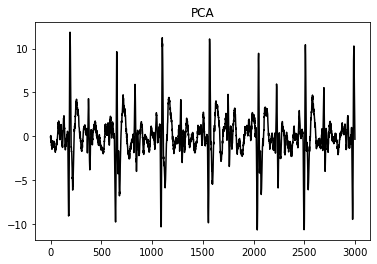

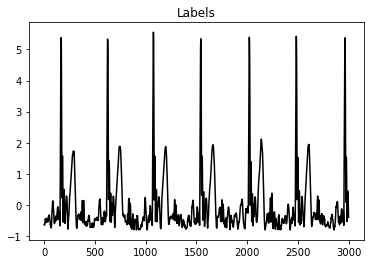

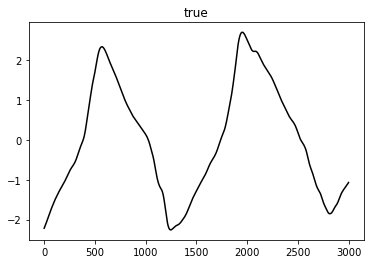

In [403]:
true_data = detrend_ts(true_data)
true_driver = np.squeeze(detrend_ts(true_driver0))

from sklearn.decomposition import PCA
embedding = PCA()
data_pca = embedding.fit_transform(true_data)[:, 0]

# model = RecurrenceManifold(random_state=0)
model = RecurrenceManifold(random_state=0,  sampling_method_pseudotime="deterministic_extreme")

curr_time()
label_vals0 = model.fit_predict(true_data)
curr_time()


plt.figure()
plt.plot(data_pca, 'k')
plt.title("PCA")

plt.figure()
plt.plot(label_vals0, 'k')
plt.title("Labels")

plt.figure()
plt.plot(true_driver, 'k')
plt.title("true")

0.08 mutual_info
0.39 conditional_info
0.95 conditional_info_back
1.1 mae
334.87 mape
31.68 marre
1.93 mse
-0.93 r2_score
1.39 rmse
140.72 smape
0.06 spearman
0.04 pearson
0.04 kendalltau
0.38 sync
0.05 coherence
0.55 coherence_phase
0.02 cross forecast error
0.01 cross forecast error neural
0.08 cross forecast error neural 2
0.3 dynamic time warping distance


0.06 mutual_info
1.05 conditional_info
1.03 conditional_info_back
1.11 mae
380.36 mape
32.07 marre
1.96 mse
-0.96 r2_score
1.4 rmse
145.64 smape
0.01 spearman
-0.02 pearson
0.01 kendalltau
0.43 sync
0.05 coherence
0.77 coherence_phase
0.02 cross forecast error
0.04 cross forecast error neural
0.14 cross forecast error neural 2
0.35 dynamic time warping distance




Text(0.5, 1.0, 'Labels vs PCA: 0.12618428203449625 4.026215521731393e-12')

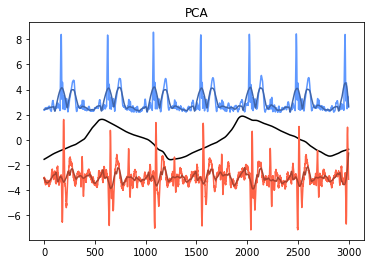

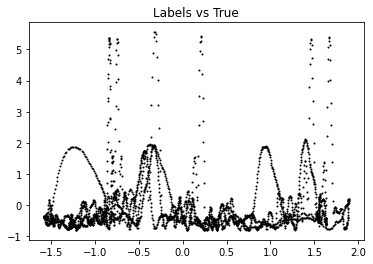

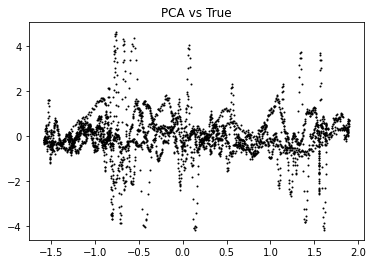

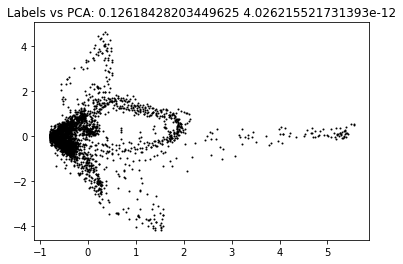

In [404]:
import degas as dg
from scipy.signal import savgol_filter
from benchmark_utils import print_dict, score_ts

true_driver = standardize_ts(true_driver)
label_vals = standardize_ts(label_vals0)
pca_vals = standardize_ts(data_pca)

## derivatives
# true_driver = np.squeeze(standardize_ts(np.diff(true_driver)[:, None]))
# label_vals = np.squeeze(standardize_ts(np.diff(nan_fill(label_vals0))[:, None]))
# pca_vals = np.squeeze(standardize_ts(np.diff(data_pca)[:, None]))

# label_vals = savgol_filter(label_vals, 131, 3)
# pca_vals = savgol_filter(pca_vals, 131, 3)

# label_vals = savgol_filter(label_vals0, 41, 3, deriv=1)
# pca_vals = savgol_filter(data_pca, 41, 3, deriv=1)
# true_driver = savgol_filter(true_driver0, 41, 3, deriv=1)


plt.figure()
plt.plot(true_driver, 'k')
plt.title("True")

# plt.figure()
plt.plot(3 + label_vals, color=dg.blue)
plt.plot(savgol_filter(3 + label_vals, 131, 3), color=dg.darker(dg.blue))
# plt.plot(np.cumsum(label_vals - np.mean(label_vals)))
plt.title("Labels")

# plt.figure()
plt.plot(-3 + pca_vals, color=dg.red)
plt.plot(savgol_filter(-3 + pca_vals , 131, 3), color=dg.darker(dg.red))
plt.title("PCA")




plt.figure()
plt.plot(true_driver, label_vals, '.k', markersize=2)
print_dict(score_ts(true_driver, label_vals))
plt.title("Labels vs True")


plt.figure()
plt.plot(true_driver, pca_vals, '.k', markersize=2)
print_dict(score_ts(true_driver, pca_vals))
plt.title("PCA vs True")

plt.figure()
plt.plot(label_vals, pca_vals, '.k', markersize=2)
corr = spearmanr(label_vals, pca_vals)
plt.title("Labels vs PCA: " + str(corr.correlation) + " " + str(corr.pvalue))


Current Time:  04:20:15
Current Time:  04:20:15
Current Time:  04:20:16
Current Time:  04:20:17
Matrix sparsity is:  0.99000001002003
Current Time:  04:20:17
asymmetry:  0.0
Current Time:  04:20:19
Assigning pseudotime labels.
....................

Current Time:  04:20:55
Current Time:  04:20:55
Current Time:  04:20:57
Current Time:  04:20:57
Matrix sparsity is:  0.99000001002003
Current Time:  04:20:57
asymmetry:  0.0
Current Time:  04:21:00
Assigning pseudotime labels.
....................

0.11353718053463388 4.5715253505361437e-10
-0.1440340529905873 2.242346424764101e-15


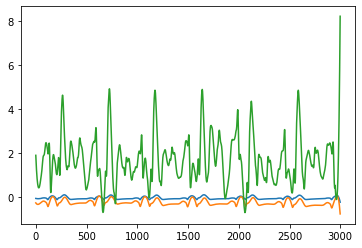

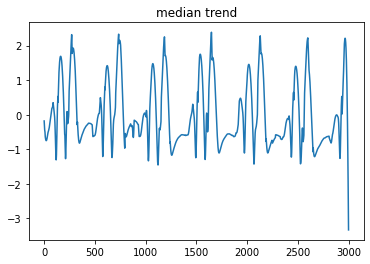

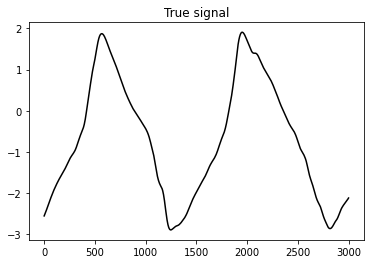

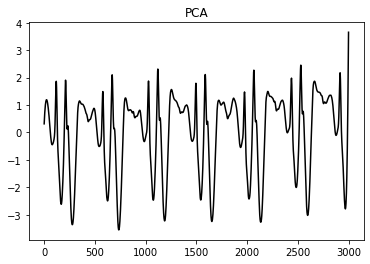

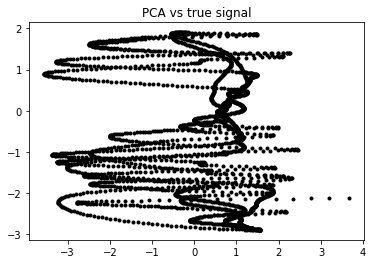

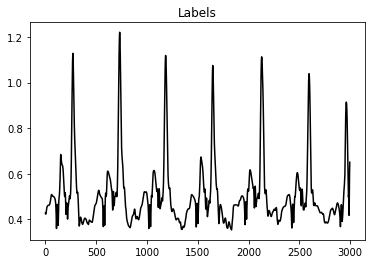

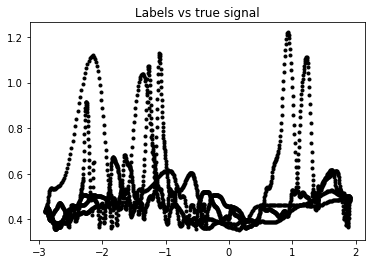

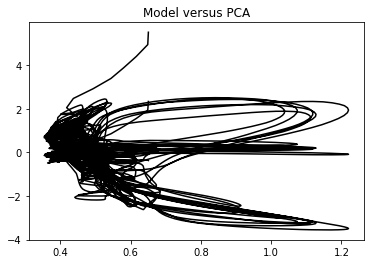

In [1610]:



# from sklearn.decomposition import PCA
# embedding = PCA()
# data_pca = embedding.fit_transform(standardize_ts(true_data))

# model = RecurrenceManifold(weighted_connectivity=True, start="multiple") 
# # model = RecurrenceManifold(weighted_connectivity=True, merge="percentile") 
# label_vals = model.fit_predict(true_data) 





# plt.figure()
# plt.plot(true_data);

# from sklearn.decomposition import PCA
# embedding = PCA()
# data_pca = embedding.fit_transform(standardize_ts(true_data))

# model = RecurrenceManifold(weighted_connectivity=True, start="multiple") 
# # model = RecurrenceManifold(weighted_connectivity=True, merge="percentile") 
# label_vals = model.fit_predict(true_data) 

# # true_drive = savgol_filter(true_drive, 151, 3)

# plt.figure()
# plt.plot(np.median(standardize_ts(true_data), axis=-1))
# plt.title("median trend")

# plt.figure()
# # plt.semilogy(label_vals, 'k')
# plt.plot(true_drive, 'k')
# plt.title("True signal")

# plt.figure()
# plt.plot(data_pca[:, 0], 'k')
# plt.title("PCA")

# plt.figure()
# plt.plot(true_drive, data_pca[:, 0], '.k')
# plt.title("PCA vs true signal")

# # model.fit(true_data, root_index=np.argmin(np.mean(standardize_ts(true_data), axis=-1)))
# plt.figure()
# plt.plot(label_vals, 'k')
# plt.title("Labels")

# plt.figure()
# # plt.semilogy(label_vals, 'k')
# plt.plot(true_drive[:len(label_vals)], label_vals, '.k')
# plt.title("Labels vs true signal")


# plt.figure()
# # plt.semilogy(label_vals, 'k')
# plt.plot(label_vals, data_pca[:len(label_vals)], 'k')
# plt.title("Model versus PCA")


# from scipy.stats import spearmanr

# corr = spearmanr(label_vals, true_drive[:len(label_vals)])
# print(corr.correlation, corr.pvalue)

# corr = spearmanr(data_pca[:, 0], true_drive)
# print(corr.correlation, corr.pvalue)


# Physiology database

EEG, ECG, and respiration signal with separate behavioral readouts

In [398]:
true_data = np.load("./resources/eeg2.pkl", allow_pickle=True)
true_driver = np.load("./resources/eeg2_drive.pkl", allow_pickle=True)
true_data = detrend_ts(true_data)
true_driver = np.squeeze(detrend_ts(true_driver))

# all_out = list()
# for row in true_data.T:
#     sig = row
#     #sig = resample(row, len(row) * 8)
#     sig = savgol_filter(sig, 51, 3)
#     all_out.append(sig)
# true_data = np.vstack(all_out).T
# true_drive = savgol_filter(true_drive, 151, 3)

Text(0.5, 1.0, 'true')

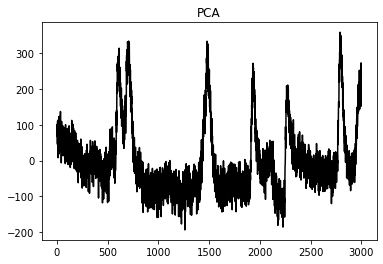

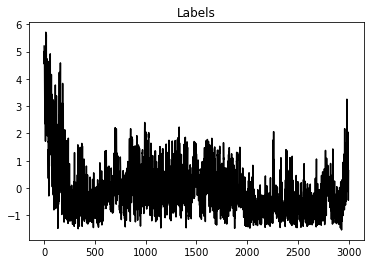

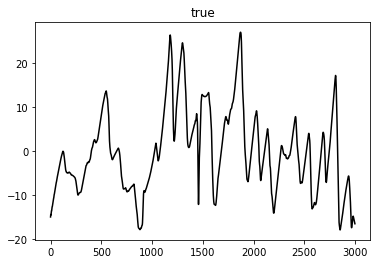

In [400]:
true_data = detrend_ts(true_data)
true_driver = np.squeeze(detrend_ts(true_driver))

from sklearn.decomposition import PCA
embedding = PCA()
data_pca = embedding.fit_transform(true_data)[:, 0]


# model = RecurrenceManifold(random_state=0, detrend=True, n_samples_pseudotime=100) 
# model = RecurrenceManifold(random_state=0)
model = RecurrenceManifold(random_state=0,  sampling_method_pseudotime="deterministic_extreme")

curr_time()
label_vals0 = model.fit_predict(true_data)
curr_time()


plt.figure()
plt.plot(data_pca, 'k')
plt.title("PCA")

plt.figure()
plt.plot(label_vals0, 'k')
plt.title("Labels")

plt.figure()
plt.plot(true_driver, 'k')
plt.title("true")

0.02 mutual_info
1.22 conditional_info
1.29 conditional_info_back
1.09 mae
546.39 mape
23.23 marre
1.87 mse
-0.87 r2_score
1.37 rmse
142.31 smape
-0.0 spearman
-0.06 pearson
-0.0 kendalltau
0.45 sync
0.05 coherence
0.7 coherence_phase
0.14 cross forecast error
0.32 cross forecast error neural
0.15 cross forecast error neural 2
0.34 dynamic time warping distance


0.04 mutual_info
1.13 conditional_info
1.2 conditional_info_back
1.03 mae
622.91 mape
21.85 marre
1.81 mse
-0.81 r2_score
1.35 rmse
136.78 smape
-0.12 spearman
-0.09 pearson
-0.08 kendalltau
0.42 sync
0.05 coherence
0.01 coherence_phase
0.12 cross forecast error
0.11 cross forecast error neural
0.16 cross forecast error neural 2
0.2 dynamic time warping distance




Text(0.5, 1.0, 'Labels vs PCA: 0.06829904669989408 0.00018132595522649797')

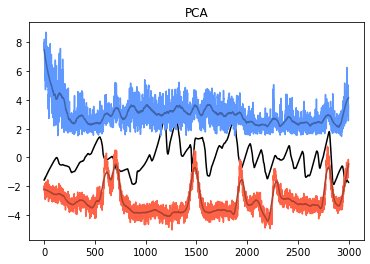

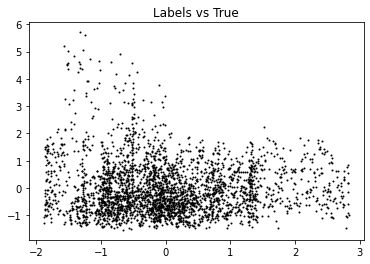

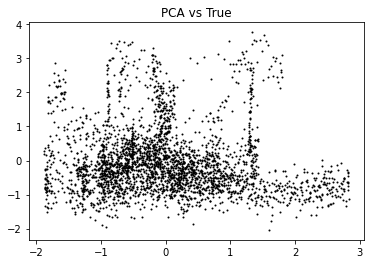

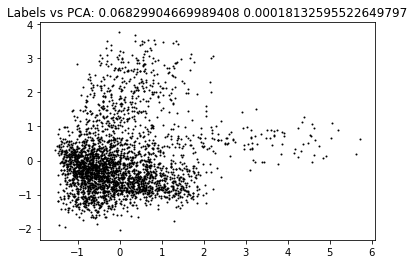

In [401]:
import degas as dg
from scipy.signal import savgol_filter

true_driver = standardize_ts(true_driver)
label_vals = standardize_ts(label_vals0)
pca_vals = standardize_ts(data_pca)

# label_vals = savgol_filter(label_vals, 131, 3)
# pca_vals = savgol_filter(pca_vals, 131, 3)

# label_vals = savgol_filter(label_vals, 131, 3, deriv=1)
# pca_vals = savgol_filter(pca_vals, 131, 3, deriv=1)
# true_driver = savgol_filter(true_driver, 11, 3, deriv=1)
# true_driver *= 10

plt.figure()
plt.plot(true_driver, 'k')
plt.title("True")

# plt.figure()
plt.plot(3 + label_vals, color=dg.blue)
plt.plot(savgol_filter(3 + label_vals, 131, 3), color=dg.darker(dg.blue))
# plt.plot(np.cumsum(label_vals - np.mean(label_vals)))
plt.title("Labels")

# plt.figure()
plt.plot(-3 + pca_vals, color=dg.red)
plt.plot(savgol_filter(-3 + pca_vals , 131, 3), color=dg.darker(dg.red))
plt.title("PCA")




plt.figure()
plt.plot(true_driver, label_vals, '.k', markersize=2)
print_dict(score_ts(true_driver, label_vals))
plt.title("Labels vs True")


plt.figure()
plt.plot(true_driver, pca_vals, '.k', markersize=2)
print_dict(score_ts(true_driver, pca_vals))
plt.title("PCA vs True")

plt.figure()
plt.plot(label_vals, pca_vals, '.k', markersize=2)
corr = spearmanr(label_vals, pca_vals)
plt.title("Labels vs PCA: " + str(corr.correlation) + " " + str(corr.pvalue))


# Natal ECG

Text(0.5, 1.0, 'median trend')

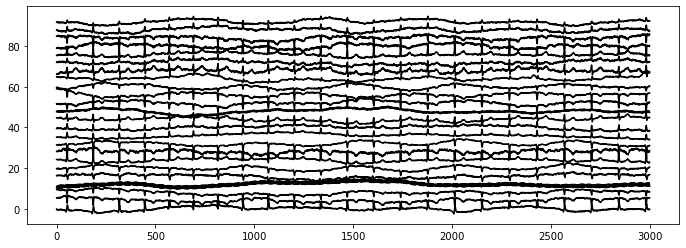

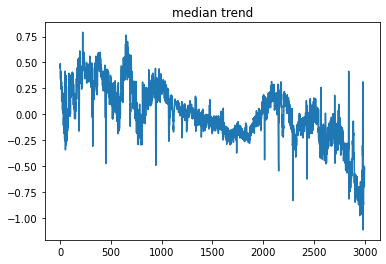

In [26]:
true_data = np.load("resources/ecg.pkl", allow_pickle=True)
true_driver0 = np.load("resources/resp.pkl", allow_pickle=True)

sort_inds = np.argsort(np.mean(true_data.T.dot(true_data), axis=0))
true_data = true_data[:, sort_inds]

import degas as dg

nt, nd = true_data.shape
aspect = (nt / nd)
plt.figure(figsize=(12, 4))
curr_max = 0
for i, row in enumerate(standardize_ts(detrend_ts(true_data)).T):
     # curr_min = np.min(row)
     # plt.plot(curr_max + row + curr_min, 'k')
     # curr_max += np.max(row) - curr_min
     plt.plot(4*i + row, 'k')
     
# plt.plot(standardize_ts(true_data));

# dg.vanish_axes()
dg.fixed_aspect_ratio(1/3)

plt.figure()
plt.plot(np.median(standardize_ts(true_data), axis=-1))
plt.title("median trend")



Current Time:  01:51:06
Current Time:  01:51:06
Computing distance matrix... Current Time:  01:51:12
done.
Current Time:  01:51:12
Matrix sparsity is:  0.9900002222222222
Current Time:  01:51:12
Assigning pseudotime labels.
test
.....................

Current Time:  01:51:54


Text(0.5, 1.0, 'true')

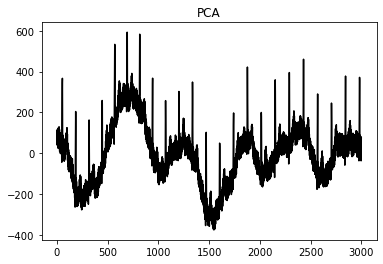

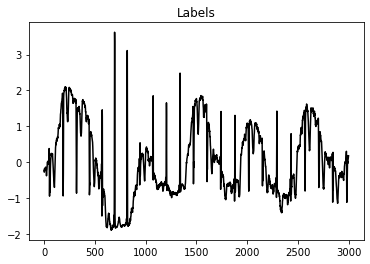

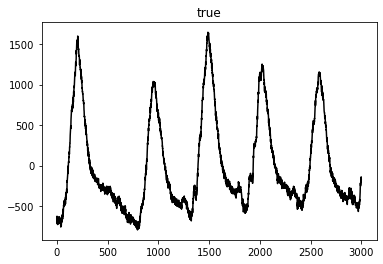

In [39]:
true_data = detrend_ts(true_data)
true_driver = np.squeeze(detrend_ts(true_driver0))

from sklearn.decomposition import PCA
embedding = PCA()
data_pca = embedding.fit_transform(true_data)[:, 0]

from models import RecurrenceManifold
# model = RecurrenceManifold(random_state=0)
model = RecurrenceManifold(random_state=0,  sampling_method_pseudotime="deterministic_extreme")
# model = RecurrenceManifold(random_state=0)

curr_time()
label_vals0 = model.fit_predict(true_data)
curr_time()


plt.figure()
plt.plot(data_pca, 'k')
plt.title("PCA")

plt.figure()
plt.plot(label_vals0, 'k')
plt.title("Labels")

plt.figure()
plt.plot(true_driver, 'k')
plt.title("true")

0.13 mutual_info
0.64 conditional_info
0.5 conditional_info_back
0.61 mae
253.41 mape
14.48 marre
0.65 mse
0.35 r2_score
0.81 rmse
88.18 smape
0.7 spearman
0.68 pearson
0.5 kendalltau
0.78 sync
0.06 coherence
0.38 coherence_phase
0.22 cross forecast error
0.22 cross forecast error neural
0.69 cross forecast error neural 2
0.14 dynamic time warping distance


0.09 mutual_info
0.96 conditional_info
0.66 conditional_info_back
0.69 mae
247.83 mape
16.28 marre
0.73 mse
0.27 r2_score
0.86 rmse
102.13 smape
-0.69 spearman
-0.63 pearson
-0.49 kendalltau
0.7 sync
0.06 coherence
0.39 coherence_phase
0.26 cross forecast error
0.26 cross forecast error neural
0.68 cross forecast error neural 2
0.19 dynamic time warping distance




Text(0.5, 1.0, 'Labels vs PCA: -0.7809466409940711 0.0')

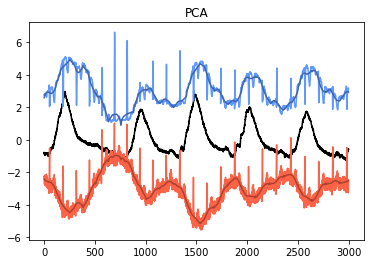

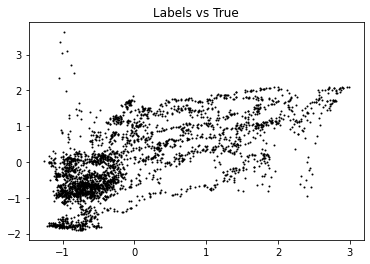

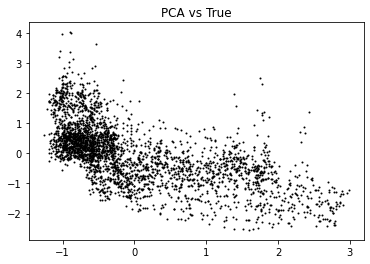

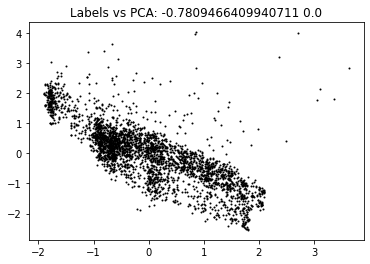

In [40]:
import degas as dg
from scipy.signal import savgol_filter
from scipy.stats import spearmanr

true_driver = np.squeeze(standardize_ts(true_driver0))
label_vals = np.squeeze(standardize_ts(nan_fill(label_vals0)))
pca_vals = np.squeeze(standardize_ts(data_pca))

## derivatives
# true_driver = np.squeeze(standardize_ts(np.diff(true_driver)[:, None]))
# label_vals = np.squeeze(standardize_ts(np.diff(nan_fill(label_vals0))[:, None]))
# pca_vals = np.squeeze(standardize_ts(np.diff(data_pca)[:, None]))

# label_vals = savgol_filter(label_vals, 131, 3)
# pca_vals = savgol_filter(pca_vals, 131, 3)

# label_vals = savgol_filter(label_vals, 131, 3, deriv=1)
# pca_vals = savgol_filter(pca_vals, 131, 3, deriv=1)
# true_driver = savgol_filter(true_driver, 11, 3, deriv=1)
# true_driver *= 10

plt.figure()
plt.plot(true_driver, 'k')
plt.title("True")

# plt.figure()
plt.plot(3 + label_vals, color=dg.blue)
plt.plot(savgol_filter(3 + label_vals, 131, 3), color=dg.darker(dg.blue))
# plt.plot(np.cumsum(label_vals - np.mean(label_vals)))
plt.title("Labels")

# plt.figure()
plt.plot(-3 + pca_vals, color=dg.red)
plt.plot(savgol_filter(-3 + pca_vals , 131, 3), color=dg.darker(dg.red))
plt.title("PCA")




plt.figure()
plt.plot(true_driver, label_vals, '.k', markersize=2)
print_dict(score_ts(true_driver, label_vals))
plt.title("Labels vs True")


plt.figure()
plt.plot(true_driver, pca_vals, '.k', markersize=2)
print_dict(score_ts(true_driver, pca_vals))
plt.title("PCA vs True")

plt.figure()
plt.plot(label_vals, pca_vals, '.k', markersize=2)
corr = spearmanr(label_vals, pca_vals)
plt.title("Labels vs PCA: " + str(corr.correlation) + " " + str(corr.pvalue))


# neonatal 
pca base: 
9, 19

heuristic single site
12, 17

## Vary the gini weight count with two sided indices
10,15
12,15
10,16
11,17
## unweighted pca
.,.
.,.
13,14
.,.



## Vary gini weight upper sided
9,17
.,.
.,.
12,15
8, 20

## Vary gini weight lower sided
14,14
.,.
11,17
11,16


# Mouse
16,17

pca base: 13, 16

## Vary the gini weight count with two sided indices
15,20
16,17
14,17
9,18

## Vary gini weight lower sided
12, 17
.,.
.,.
6, 22

## Vary gini weight upper sided
15,20
.,.
14,22
13,22

## both side unweighted PCA
10,20
.,.
.,.
7,19

## both side jitter weight PCA
12,21
.,.
.,.
7,22


In [ ]:
# true_data = np.load("ecg2.pkl", allow_pickle=True)
# true_driver = np.load("drive_ecg2.pkl", allow_pickle=True)


# from scipy.ndimage import gaussian_filter1d 
# all_out = list()
# for row in true_data.T:
#     sig = row
#     #sig = resample(row, len(row) * 8)
#     #sig = savgol_filter(sig, 501, 3)
#     sig = gaussian_filter1d(sig, 61)
#     all_out.append(sig)
# true_data = np.vstack(all_out).T
# true_driver = gaussian_filter1d(true_driver, 61)

# plt.figure()
# plt.plot(true_data);

# from sklearn.decomposition import PCA
# embedding = PCA()
# data_pca = embedding.fit_transform(standardize_ts(true_data))
# plt.figure()
# plt.plot(data_pca[:, 0], 'k')
# plt.title("PCA")
# plt.plot(data_pca[:, 0], true_driver, 'k')


# plt.figure()
# plt.plot(np.median(standardize_ts(true_data), axis=-1))
# plt.title("median trend")


# model = RecurrenceManifold(weighted_connectivity=True, start="multiple") 
# # model = RecurrenceManifold(weighted_connectivity=True, merge="percentile") 
# label_vals = model.fit_predict(true_data) 

# plt.figure()
# plt.plot(true_driver, 'k')
# plt.title("true signal")

# plt.figure()
# plt.plot(label_vals, 'k')

# plt.figure()
# # plt.semilogy(label_vals, 'k')
# plt.plot(label_vals, true_driver[:len(label_vals)][:], 'k')

# Fluid mixing

Text(0.5, 1.0, 'median trend')

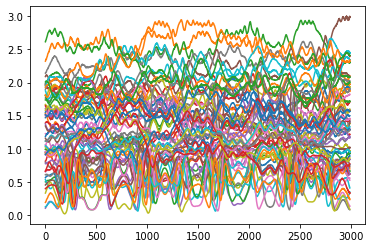

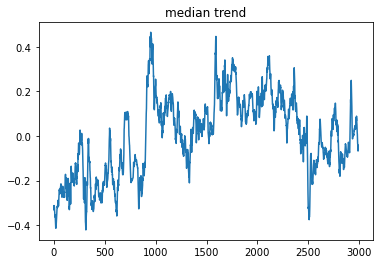

In [31]:
# dpath = "/Users/williamgilpin/Downloads/gyre.pkl"
# all_data = np.load(dpath, allow_pickle=True)

dpath = "/Users/williamgilpin/Downloads/gyre.pkl"
all_data1 = np.load(dpath, allow_pickle=True)
dpath = "/Users/williamgilpin/Downloads/gyre2.pkl"
all_data2 = np.load(dpath, allow_pickle=True)
all_data = np.vstack([all_data1, all_data2])

# dpath = "/Users/williamgilpin/Downloads/gyre3.pkl"
# all_data = np.load(dpath, allow_pickle=True)

# dpath = "/Users/williamgilpin/Downloads/gyre_n2.pkl"
# all_data = np.load(dpath, allow_pickle=True)

# dpath = "/Users/williamgilpin/Downloads/gyre_p1.pkl"
# all_data = np.load(dpath, allow_pickle=True)



# dpath = "/Users/williamgilpin/Downloads/gyre_p1.pkl"
# all_data1 = np.load(dpath, allow_pickle=True)
# dpath = "/Users/williamgilpin/Downloads/gyre_p2.pkl"
# all_data2 = np.load(dpath, allow_pickle=True)
# all_data = np.vstack([all_data1, all_data2])


# dpath = "/Users/williamgilpin/Downloads/gyre_g1.pkl"
# all_data1 = np.load(dpath, allow_pickle=True)
# dpath = "/Users/williamgilpin/Downloads/gyre_g2.pkl"
# all_data2 = np.load(dpath, allow_pickle=True)
# all_data = np.vstack([all_data1, all_data2])


## OK
# dpath = "/Users/williamgilpin/Downloads/gyre_g3.pkl"
# all_data1 = np.load(dpath, allow_pickle=True)
# dpath = "/Users/williamgilpin/Downloads/gyre_g4.pkl"
# all_data2 = np.load(dpath, allow_pickle=True)
# dpath = "/Users/williamgilpin/Downloads/gyre_g5.pkl"
# all_data3 = np.load(dpath, allow_pickle=True)
# all_data = np.vstack([all_data2, all_data1, all_data3])

# dpath = "/Users/williamgilpin/Downloads/gyre_g4.pkl"
# all_data = np.load(dpath, allow_pickle=True)


# dpath = "/Users/williamgilpin/Downloads/gyre_h2.pkl"
# all_data = np.load(dpath, allow_pickle=True)

# OK
# dpath = "/Users/williamgilpin/Downloads/gyre_h1.pkl"
# all_data1 = np.load(dpath, allow_pickle=True)
# dpath = "/Users/williamgilpin/Downloads/gyre_h2.pkl"
# all_data2 = np.load(dpath, allow_pickle=True)
# dpath = "/Users/williamgilpin/Downloads/gyre_h3.pkl"
# all_data3 = np.load(dpath, allow_pickle=True)
# all_data = np.vstack([all_data1, all_data2, all_data3])


## Good
dpath = "/Users/williamgilpin/Downloads/gyre_n2_noise.pkl"
all_data1 = np.load(dpath, allow_pickle=True)
dpath = "/Users/williamgilpin/Downloads/gyre_n2_noise2.pkl"
all_data2 = np.load(dpath, allow_pickle=True)
dpath = "/Users/williamgilpin/Downloads/gyre_n2_noise3.pkl"
all_data3 = np.load(dpath, allow_pickle=True)
dpath = "/Users/williamgilpin/Downloads/gyre_n2_noise4.pkl"
all_data4 = np.load(dpath, allow_pickle=True)
dpath = "/Users/williamgilpin/Downloads/gyre_n2_noise5.pkl"
all_data5 = np.load(dpath, allow_pickle=True)
all_data = np.vstack([all_data1, all_data2, all_data3, all_data4, all_data5])
all_data = np.vstack([all_data1, all_data2, all_data3])

# dpath = "/Users/williamgilpin/Downloads/gyre_n2_noise.pkl"
# all_data = np.load(dpath, allow_pickle=True)


# true_driver = all_data[0, :, -1]
# true_data = np.swapaxes(all_data[:, :, 0], 0, -1)
true_data = np.sqrt(all_data[:, :, 0]**2 + all_data[:, :, 1]**2).T
# true_data = np.arctan2(all_data[:, :, 1], all_data[:, :, 0]).T
# true_data = detrend_ts(all_data[:, :, 0].T)
# true_data = all_data[:, :, 1].T
# true_data = all_data[:, :, 0].T


true_driver0 = all_data[0, :, -1]
true_data = true_data[:-10]
true_driver0 = true_driver0[:-10]


plt.figure()
plt.plot(true_data);


plt.figure()
plt.plot(np.median(standardize_ts(true_data), axis=-1))
plt.title("median trend")


Current Time:  01:48:24
Current Time:  01:48:24
Computing distance matrix... Current Time:  01:48:37
done.
Current Time:  01:48:37
Matrix sparsity is:  0.9900001118555721
Current Time:  01:48:37
Assigning pseudotime labels.
test
.....................

Current Time:  01:49:16


Text(0.5, 1.0, 'true')

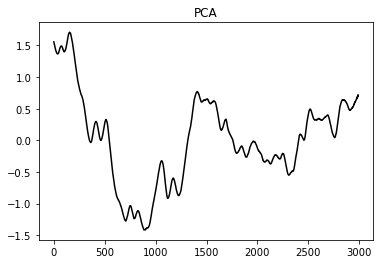

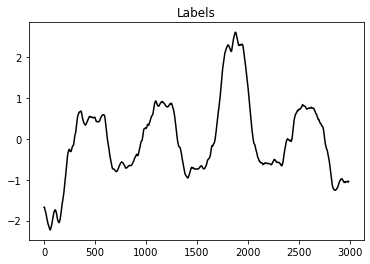

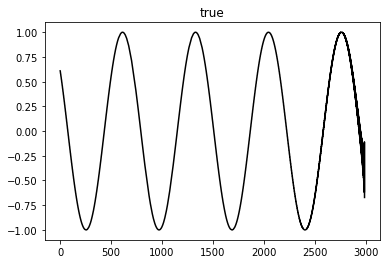

In [35]:
true_data = detrend_ts(true_data)
true_driver = np.squeeze(detrend_ts(true_driver0[:, None]))

from sklearn.decomposition import PCA
embedding = PCA()
data_pca = embedding.fit_transform(true_data)[:, 0]

from models import RecurrenceManifold
# model = RecurrenceManifold(random_state=0, n_samples_pseudotime=2, sampling_method_pseudotime="deterministic_extreme")
model = RecurrenceManifold(random_state=0, sampling_method_pseudotime="deterministic_extreme")
# model = RecurrenceManifold(random_state=0)

curr_time()
label_vals0 = model.fit_predict(true_data)
curr_time()


plt.figure()
plt.plot(data_pca, 'k')
plt.title("PCA")

plt.figure()
plt.plot(label_vals0, 'k')
plt.title("Labels")

plt.figure()
plt.plot(true_driver0, 'k')
plt.title("true")

Text(0.5, 1.0, 'Labels')

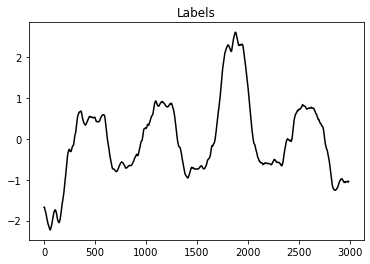

In [36]:
plt.figure()
plt.plot(label_vals0, 'k')
plt.title("Labels")

0.13 mutual_info
0.53 conditional_info
0.59 conditional_info_back
1.17 mae
1024.38 mape
40.32 marre
1.9 mse
-0.9 r2_score
1.38 rmse
134.8 smape
0.03 spearman
0.05 pearson
0.02 kendalltau
0.32 sync
0.04 coherence
0.97 coherence_phase
0.03 cross forecast error
0.01 cross forecast error neural
0.2 cross forecast error neural 2
0.09 dynamic time warping distance


0.13 mutual_info
0.72 conditional_info
0.61 conditional_info_back
1.11 mae
911.11 mape
38.45 marre
1.83 mse
-0.83 r2_score
1.35 rmse
136.36 smape
0.12 spearman
0.08 pearson
0.08 kendalltau
0.38 sync
0.05 coherence
0.9 coherence_phase
0.02 cross forecast error
0.04 cross forecast error neural
0.17 cross forecast error neural 2
0.27 dynamic time warping distance




Text(0.5, 1.0, 'Labels vs PCA: 0.2458029869261832 1.9121791900759396e-38')

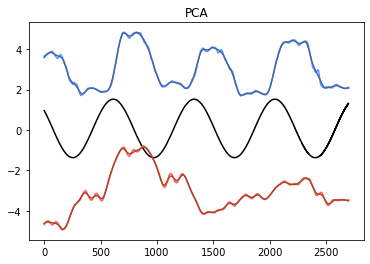

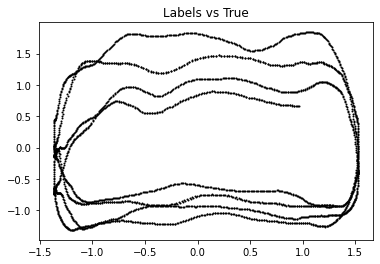

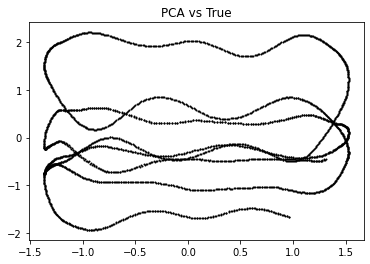

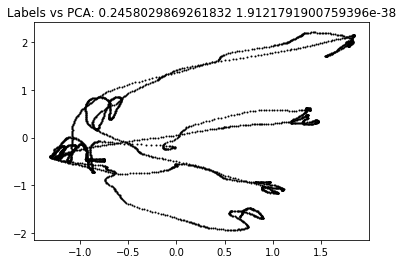

In [166]:
import degas as dg
from scipy.signal import savgol_filter
from benchmark_utils import print_dict, score_ts

from scipy.stats import spearmanr

true_driver = standardize_ts(true_driver0)
label_vals = standardize_ts(label_vals0)
pca_vals = standardize_ts(data_pca)

## derivatives
# true_driver = np.squeeze(standardize_ts(np.diff(true_driver)[:, None]))
# label_vals = np.squeeze(standardize_ts(np.diff(nan_fill(label_vals0))[:, None]))
# pca_vals = np.squeeze(standardize_ts(np.diff(data_pca)[:, None]))

# label_vals = savgol_filter(label_vals, 131, 3)
# pca_vals = savgol_filter(pca_vals, 131, 3)

# label_vals = savgol_filter(label_vals0, 41, 3, deriv=1)
# pca_vals = savgol_filter(data_pca, 41, 3, deriv=1)
# true_driver = savgol_filter(true_driver0, 41, 3, deriv=1)


plt.figure()
plt.plot(true_driver, 'k')
plt.title("True")

# plt.figure()
plt.plot(3 + label_vals, color=dg.blue)
plt.plot(savgol_filter(3 + label_vals, 131, 3), color=dg.darker(dg.blue))
# plt.plot(np.cumsum(label_vals - np.mean(label_vals)))
plt.title("Labels")

# plt.figure()
plt.plot(-3 + pca_vals, color=dg.red)
plt.plot(savgol_filter(-3 + pca_vals , 131, 3), color=dg.darker(dg.red))
plt.title("PCA")




plt.figure()
plt.plot(true_driver, label_vals, '.k', markersize=2)
print_dict(score_ts(true_driver, label_vals))
plt.title("Labels vs True")


plt.figure()
plt.plot(true_driver, pca_vals, '.k', markersize=2)
print_dict(score_ts(true_driver, pca_vals))
plt.title("PCA vs True")

plt.figure()
plt.plot(label_vals, pca_vals, '.k', markersize=2)
corr = spearmanr(label_vals, pca_vals)
plt.title("Labels vs PCA: " + str(corr.correlation) + " " + str(corr.pvalue))


wPCA (2990, 21)
(2990, 21) (21, 21)
wPCA (2990, 21)
(2990, 21) (21, 21)
wPCA (2990, 21)
(2990, 21) (21, 21)
wPCA (2990, 21)
(2990, 21) (21, 21)


Text(0.5, 1.0, 'Jitter weighted PCA')

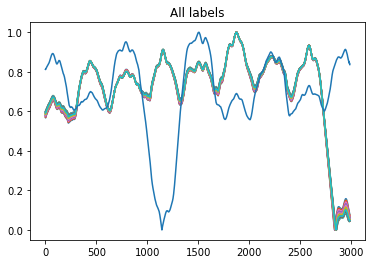

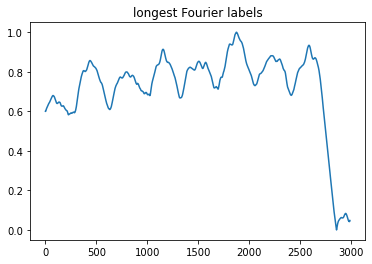

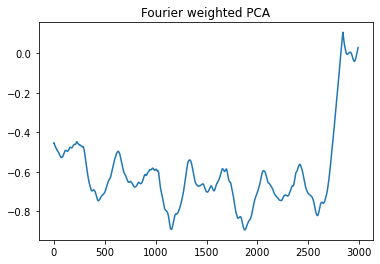

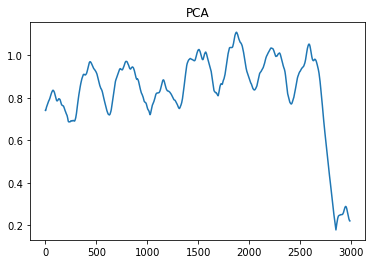

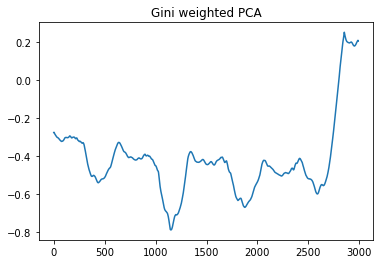

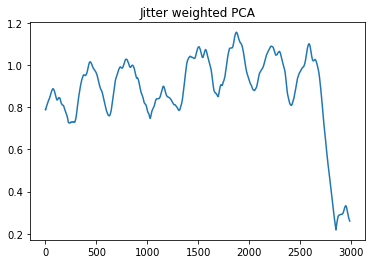

In [217]:



# xx = np.random.random(size=500)
# dmat = scipy.spatial.distance.cdist(xx[:, None], xx[:, None])

# neighbor_matrix = distance_to_connectivity(dmat)

# print(np.argmin(xx), np.argmax(xx))

# spec = [item[::-1] for item in np.linalg.eigh(dmat)]

# print(np.argmin(np.min(neighbor_matrix, axis=1)))
# # print(np.argmin(np.min(hollow_matrix(1/(neighbor_matrix + 1e-16)), axis=1)))

# print(
#     np.argmax((xx * spec[1])[0]),
#     np.argmin((xx * spec[1])[0]),
# )


# xx = np.sin(np.linspace(0, 2*np.pi * 5, 500)) + 0.5*np.random.random(size=500)
# xxp = np.abs(xx)
# xxpp = np.abs(xx + 0.5)
# all_labels = [xx, xxp, xxpp]
all_freqs = list()
all_labels = model.all_labelings
# all_labels = [(item - np.min(item)) / (np.max(item) - np.min(item)) for item in all_labels]
for labels in all_labels:
    freqs, wgts = find_psd(nan_fill(labels))
    freq_mn = np.sum(freqs * wgts) / np.sum(wgts)
    #freq_mn = np.median(np.diff(labels))
    all_freqs.append(freq_mn)
wgts = (1 / (np.array(all_freqs) + 1e-16))
wgts /= np.sum(wgts)
sel_ind = np.argmin(all_freqs)


plt.figure()
plt.plot(all_labels.T);
plt.title("All labels")

plt.figure()
plt.plot(all_labels[sel_ind])
plt.title("longest Fourier labels")

w1 = nan_pca(all_labels.T, weights=wgts)[0]
plt.figure()
plt.plot(np.dot(all_labels.T, w1))
plt.title("Fourier weighted PCA")


plt.figure()
w1 = nan_pca(all_labels.T, weights=None)[0]
plt.plot(np.dot(all_labels.T, w1))
plt.title("PCA")


## best so far
jitter_vals = np.sum(
    (np.sort(all_labels, axis=1) - np.linspace(0, 1, all_labels.shape[1])[None, :])**2,
    axis=1
)
data_weights = 1 / (jitter_vals + 1e-6)
data_weights = data_weights / np.sum(data_weights)
w1 = nan_pca(all_labels.T, weights=data_weights)[0]
plt.figure()
plt.plot(np.dot(all_labels.T, w1))
plt.title("Gini weighted PCA")



jitter_vals = np.var(np.diff(np.sort(all_labels, axis=1), axis=1), axis=1)
data_weights = 1 / (jitter_vals + 1e-6)
data_weights = data_weights / np.sum(data_weights)
w1 = nan_pca(all_labels.T, weights=data_weights)[0]
plt.figure()
plt.plot(np.dot(all_labels.T, w1))
plt.title("Jitter weighted PCA")

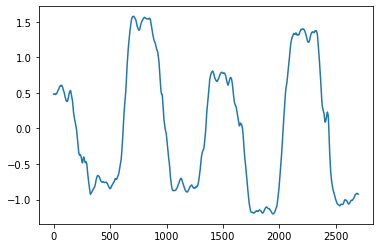

In [162]:
plt.plot(
    PCA().fit_transform(np.array([nan_fill(item) for item in all_labels]).T)[:, 0]
)



## Datasets

+ Plankton
+ Fetus / Physionet
+ Fitness tracker
+ Fluids

# Appendix

In [ ]:



def dstack_to_connectivity(dstack):
    """
    Given a stack of M pairwise distance matrices of shape N x N x M, compute a 
    single consolidated N x N connectivity or adjacency matrix
    
    Args:
        dstack (array-like): A batch of pairwise distance matrices stacked along the 
            last axis
    """
    
#     bdstack = distance_to_connectivity(dstack) # connectivity matrix
#     dscale = np.mean(dstack, axis=(0, 1), keepdims=True)
#     weights = np.exp(-dstack / dscale) # weights scale each connection by batch scale
#     return np.sum(weights * bdstack, axis=-1)

    nb = dstack.shape[-1]
    all_cmats = list()
    for i in range(nb):
        all_cmats.append(
            distance_to_connectivity(
                dstack[..., i], 
                dscale=np.mean(dstack[..., i])
            )
        )
    bdstack = np.dstack(all_cmats)
    return np.sum(bdstack, axis=-1)

    
#     nb = dstack.shape[-1]
#     all_cmats = list()
#     for i in range(nb):
#         all_cmats.append(distance_to_connectivity(dstack[..., i]))
#     bdstack = np.dstack(all_cmats)
    
#     return np.min(bdstack, axis=-1)
    #return np.sum(bdstack, axis=-1)

#     nb = dstack.shape[-1]
#     all_cmats = list()
#     for i in range(nb):
#         all_cmats.append(distance_to_connectivity(dstack[..., i]))
#     bdstack = np.dstack(all_cmats)
#     return np.sum(bdstack, axis=-1)
    
#     # find kNN for each distance matrix separately, then consolidate somehow?
#     # the min says "once a neigbor, always a neighbor"
    
    
#     Neighbors are defined relative to others in same batch member.
#     Pooling after neighbor assignment is helpful for when the response subsystems are really different
    
    
#     How does this work? Assign neighbors 
    
#     take mean of each batch example and scale the distance matrix by it (add 1e-16 for conditioning)
    

        
        # connectivity ranked locally for each frame
        # next we need to pool across frames. min pooling
        # try sum pooling
        
        
        # can also try normalizing connectivity based on all frames, to get a global estimate
        
    

